In [156]:
import pandas as pd
import geopandas as gp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm
from importlib import reload
from glob import glob
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
import covid_commons as g
from covid_commons import peek
g = reload(g)

# Prepare data

## Load city data

### Create the cities

In [3]:
# load the city information
cities = g.load_cities()

# create new variables for Chicago & NYC & update the cities list
nyc = cities['nyc']
chi = cities['chi']

In [4]:
il = g.City('il', {
    'name': 'Illinois',
    'events': {},
    'counties': {x[-3:]: [17, int(x[-3:])] for x in
                 glob(g.DATA_DIR+'/county_wise/17/*')}
})

In [5]:
nyc.name = 'NYC'
nyc.full_name = 'New York City'
chi.full_name = 'Chicago'
nyc.color = 'dodgerblue'
chi.color = 'blueviolet'
il.full_name = 'Illinois'
il.color = 'tomato'

In [6]:
# cities = [chi, nyc]
cities = [nyc, il]

### Load the pickled data

In [7]:
%%time
for c in tqdm(cities):
    g.load_city_data(c, exclude=['pat_od'], pat_vars=['dwells'])
    
    # combine patterns with dwell bin visits
    c.pat = pd.concat([c.pat, c.dwells], axis=1).drop(columns=['poi_cbg'])
    del c.dwells
    
    # add the exposure data to the patterns table & then delete it
    c.exp_daily = c.exp.copy()
    c.exp = (c.exp.reset_index()
             .assign(week = lambda x:
                     g.date2int(g.get_week(g.int2date(x['date']))))
             .drop(columns=['date'])
             .assign(tot_cei = lambda x: x['cei']*x['exp_visits'])
             .groupby(['poi_id', 'week'])
             [['exp_visits', 'tot_cei']].sum()
             .assign(cei = lambda x: x['tot_cei']/x['exp_visits'])
             .astype({'cei': np.float32, 'tot_cei': np.float32,
                      'exp_visits': np.int32}))
    c.pat = c.pat.merge(c.exp, on=('poi_id', 'week'))


CPU times: user 2min 58s, sys: 37.7 s, total: 3min 36s
Wall time: 4min 4s


## Cases/deaths

### NYC

In [8]:
def set_nyc_cases():
    """
    For NYC, the cases data is broken into two parts.
    1. The first part contains values before May 18 and are retrieved from an
    independent Github repo. This table has fewer variables.
    2. The second part contains values on and after May 19 and are collected
    from an official source of the government of NYC. This table has more
    variables like testing rate.
    These two sources have to be combined appropriately but values of one
    particular day (April 26) have to be adjusted because of miscalculation.
    """
    ## before May 18
    # first get the raw data
    cases_old = (
        pd.read_csv(g.IO['nyc_cases_old'])
        .assign(date = lambda x: g.str2date(x['timestamp'].str.slice(0, 10)))
        .drop(columns=['timestamp'])
        .rename(columns={'zcta': 'zip', 'positive': 'cum_cases',
                         'total': 'cum_tests'})
        .query('zip != 99999') # this zip does not exist in reality
        .dropna()
        .astype({'zip': int})
    )
    # 26 Apr is an outlier with a sudden increase in cum. cases with a decline
    # in cum. cases on 27 Apr, so make 26 Apr values avg. of 25 & 27 Apr
    # similarly, 6th Apr data is unavailable, so use avg. of 5 & 7 Apr
    temp = pd.DataFrame()
    for zip_, df in cases_old.groupby('zip'):
        df = df.set_index('date')
        df.loc[g.str2date('2020-04-06')] = np.nan
        for date in g.str2date(pd.Series(['2020-04-06', '2020-04-26'])):
            prev = df.loc[date - pd.DateOffset(1)]
            next_ = df.loc[date + pd.DateOffset(1)]
            df.loc[date] = 0.5*(prev + next_)
        temp = temp.append(df.reset_index(), ignore_index=True)
    cases_old = temp.copy().sort_values('date')

    
    # combine these two units
    cases_old = (
        cases_old.merge(
            cases_old
            .groupby('zip')
            .apply(lambda x: x.set_index('date').diff())
            .rename(columns={'cum_cases': 'new_cases',
                             'cum_tests': 'new_tests'})
            .dropna()
            .astype({'new_cases': int, 'new_tests': int})
            .drop(columns=['zip']),
            on=('zip', 'date'))
        .dropna()
        .set_index(['zip', 'date'])
        .reset_index()
    )
    
    # after May 18
    cases_new = (
        pd.read_csv(g.IO['nyc_cases_new'])
        .rename(columns=lambda x: x.lower().replace('covid_', ''))
        .rename(columns={'modified_zcta': 'zip', 'pop_denominator': 'popu',
                         'percent_positive': 'pct_positive',
                         'total_tests': 'cum_tests', 'case_count': 'cum_cases',
                         'death_count': 'cum_deaths'})
        .drop(columns=['neighborhood_name'])
        .assign(date = lambda x: g.str2date(x['date']))
        .set_index(['zip', 'date'])
        .reset_index()
        .drop_duplicates(subset=['zip', 'date'])
    )
    cases_new = (
        cases_new.merge(
            cases_new
            .sort_values('date')
            [['zip', 'date', 'cum_cases', 'cum_deaths', 'cum_tests']]
            .groupby('zip')
            .apply(lambda x: x.set_index('date').diff())
            .rename(columns=lambda x: x.replace('cum', 'new'))
            .fillna(0)
            .drop(columns=['zip'])
            .reset_index(),
            on=('zip', 'date')
        )
    )
    # combine the old and new cases
    cases = (
        cases_old.append(cases_new[['zip', 'date', 'cum_cases', 'cum_tests',
                                    'new_cases', 'new_tests']])
            .sort_values(['zip', 'date'])
#             .astype({'cum_cases': int, 'cum_tests': int})
            .assign(week = lambda x: g.get_week(x['date']))
    )
    # set these as object members
    nyc.cases_old = cases_old
    nyc.cases_new = cases_new
    nyc.cases = cases

In [9]:
set_nyc_cases()
peek(nyc.cases)

Shape: (36476, 7), Memory: 2.226 MB


zip       date  cum_cases  cum_tests  new_cases  new_tests       week
170  10001.0 2020-04-03      136.0      304.0       23.0       39.0 2020-03-30
301  10001.0 2020-04-04      146.0      321.0       10.0       17.0 2020-03-30
371  10001.0 2020-04-05      158.0      337.0       12.0       16.0 2020-03-30

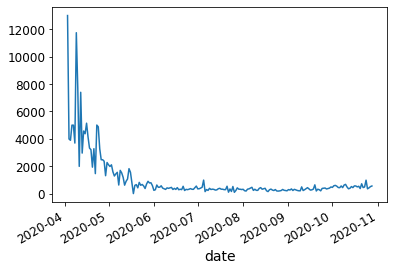

In [10]:
nyc.cases.groupby('date').new_cases.sum().plot();

#### Set important zip codes
These zip codes are the ones which contain the case data.

In [11]:
nyc.imp_zips = pd.Series(nyc.cases['zip'].unique(), name='zip')

### Illinois

In [12]:
il.cases = (pd.read_csv(g.IO['il_cases'])
            .rename(columns={'zipcode': 'zip'})
            .assign(date = lambda x: g.str2date(x['date']))
            .rename(columns=lambda x: x.replace('confirmed_', 'cum_')
                    .replace('total_tested', 'tests'))
            .rename(columns={'cum_cases_change': 'new_cases',
                             'tests_change': 'new_tests',
                             'tests': 'cum_tests'})
            .set_index(['zip', 'date'])
            .apply(lambda x: np.clip(x, 0, np.inf))
            .reset_index())
peek(il.cases, top=2)

Shape: (191544, 48), Memory: 70.146 MB


zip       date  cum_cases  new_cases  cum_cases_change_pct  \
0  62999 2020-12-03         75          2                  2.74   
1  62998 2020-12-03         16          0                  0.00   

   cum_cases_20_to_29  cum_cases_30_to_39  cum_cases_40_to_49  \
0                  12                  12                  16   
1                   0                   0                   0   

   cum_cases_50_to_59  cum_cases_60_to_69  ...  tests_female  tests_hispanic  \
0                  10                  13  ...           495               0   
1                   0                   0  ...           101               0   

   tests_leftblank  tests_less_than_20  tests_male  tests_nhpi  tests_unknown  \
0              193                  81         294           0              0   
1                0                   0          60           0              0   

   tests_other  tests_unknownleftblank  tests_white  
0            0                       0          643  
1            0                       0          131  

[2 rows x 48 columns]

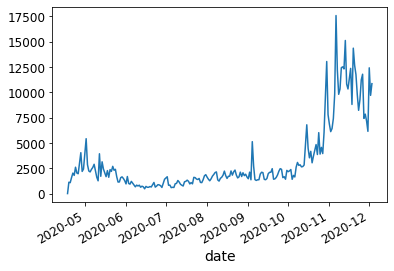

In [13]:
il.cases.groupby('date').new_cases.sum().plot();

In [14]:
il.imp_zips = pd.Series(il.cases['zip'].unique(), name='zip')

### Chicago

In [15]:
chi.zips = (g.map_cbg_zip(il.acs.index)
            .assign(cnty = lambda x: (x['cbg']//1e7).astype(int))
            .pipe(lambda x: x[x['cnty'].isin([x[0]*1000+x[1] for x in
                                              chi.counties.values()])])
            ['zip'].drop_duplicates())

In [16]:
chi.pois = il.pois[il.pois['zip'].isin(chi.zips)]

In [17]:
chi.cases = il.cases[il.cases['zip'].isin(chi.zips)]

In [18]:
chi.exp_daily = (il.exp_daily.reset_index()
                 .merge(il.pois['cbg'], on='poi_id')
                 .assign(cnty=lambda x: x['cbg']//1e7)
                 .pipe(lambda x: x[x['cnty'].isin([x[0]*1000+x[1] for x in
                                                   chi.counties.values()])])
                 .set_index(['date', 'poi_id'])
                 .drop(columns=['cbg', 'cnty']))

In [19]:
chi.imp_zips = pd.Series(chi.cases['zip'].unique(), name='zip')

#### Set important zip codes
These zip codes are the ones which contain the case data.

## Zip code data

### National

In [20]:
zip2tract = g.load_all_zips()
peek(zip2tract)

Shape: (148897, 6), Memory: 5.680 MB


zip  state  county        geoid   zpop  zarealand
0  601     72       1  72001956300  18570  166659789
1  601     72       1  72001956400  18570  166659789
2  601     72       1  72001956500  18570  166659789

In [21]:
%%time
zips_shp = (gp.read_file(g.IO['zips_shp'])
            .rename(columns={'ZCTA5CE10': 'zip'})
            .astype({'zip': np.int32}))
peek(zips_shp)

Shape: (33144, 6), Memory: 5.089 MB
CPU times: user 5.61 s, sys: 167 ms, total: 5.77 s
Wall time: 6.31 s


zip      AFFGEOID10 GEOID10    ALAND10  AWATER10  \
0  36083  8600000US36083   36083  659750662   5522919   
1  35441  8600000US35441   35441  172850429   8749105   
2  35051  8600000US35051   35051  280236456   5427285   

                                            geometry  
0  MULTIPOLYGON (((-85.63225 32.28098, -85.62439 ...  
1  MULTIPOLYGON (((-87.83287 32.84437, -87.83184 ...  
2  POLYGON ((-86.74384 33.25002, -86.73802 33.251...

### Zip shapefile & mapping to CBG

In [22]:
nyc.shp_zip = (gp.read_file(glob(nyc.dir+'/shapefile_zip/*.shp')[0])
               .rename(columns={'postalCode': 'zip'})
               [['zip', 'geometry']]
               .astype({'zip': np.int32}))

In [23]:
il.shp_zip = (zips_shp.merge(zip2tract.query('state == 17')['zip'], on='zip')
              [['zip', 'geometry']])

In [24]:
chi.shp_zip = il.shp_zip.pipe(lambda x: x[x['zip'].isin(chi.zips)])

### Prepare the zip-level data

In [25]:
def get_acs_by_zip(city):
    """
    Aggregate relevant census CBG-level variables over zip codes.
    It's important to use the correct measures & aggregation technique here.
    """
    # get the mapping between CBG & zip code
    zip2cbg = g.map_cbg_zip(city.acs.index, zip2tract)
    # remove 0 population CBGs
    acs = city.acs.query('tot_pop > 0')
    grp = acs.merge(zip2cbg, on='cbg').groupby('zip')
    x = grp[['tot_pop', 'tot_hh', 'tot_income', 'tot_hh_income']].sum().astype(int)
    x['avg_income'] = x['tot_income']/x['tot_pop']
    x['avg_hh_income'] = x['tot_hh_income']/x['tot_hh']
    x['inc_bin'] = g.get_inc_classes(x['avg_income'])
    x['hh_inc_bin'] = g.get_inc_classes(x['avg_hh_income'])
    x['inc_q'] = x['inc_bin'].cat.codes + 1
    x['hh_inc_q'] = x['hh_inc_bin'].cat.codes + 1
    for var in g.VUL_VARS:
        x[var] = grp.apply(g.wtd_avg, val=var, wt='tot_pop')
    return x

In [26]:
for c in cities:
    c.acs_zip = get_acs_by_zip(c)
peek(nyc.acs_zip, top=2)

Shape: (176, 16), Memory: 0.019 MB


tot_pop  tot_hh  tot_income  tot_hh_income    avg_income  \
zip                                                               
10001    43898   23989  4289277400     4128960500  97710.087020   
10002    82015   34984  2355576600     2173147800  28721.290008   

       avg_hh_income                  inc_bin                hh_inc_bin  \
zip                                                                       
10001  172118.908666  (45070.773, 196954.622]  (100524.403, 310580.327]   
10002   62118.334096   (25947.574, 32197.228]    (59378.186, 72712.466]   

       inc_q  hh_inc_q  frac_poor  frac_low_edu  frac_old  frac_female  \
zip                                                                      
10001      5         5   0.532339      0.278937  0.112351     0.480204   
10002      3         2   0.590742      0.676851  0.183783     0.522478   

       frac_black  frac_transit  
zip                              
10001    0.074195      0.449564  
10002    0.090800      0.547970

In [27]:
chi.acs_zip = il.acs_zip.pipe(lambda x: x[x.index.isin(chi.zips)])

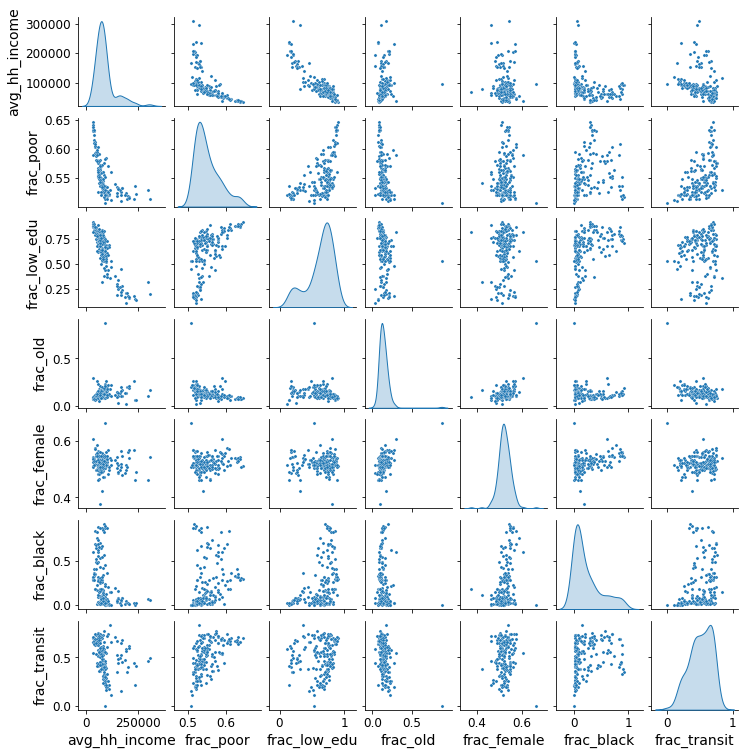

In [28]:
sns.pairplot((nyc.acs_zip
              [['avg_hh_income'] + g.VUL_VARS]),
              diag_kind='kde', height=1.5, plot_kws={'s': 10});

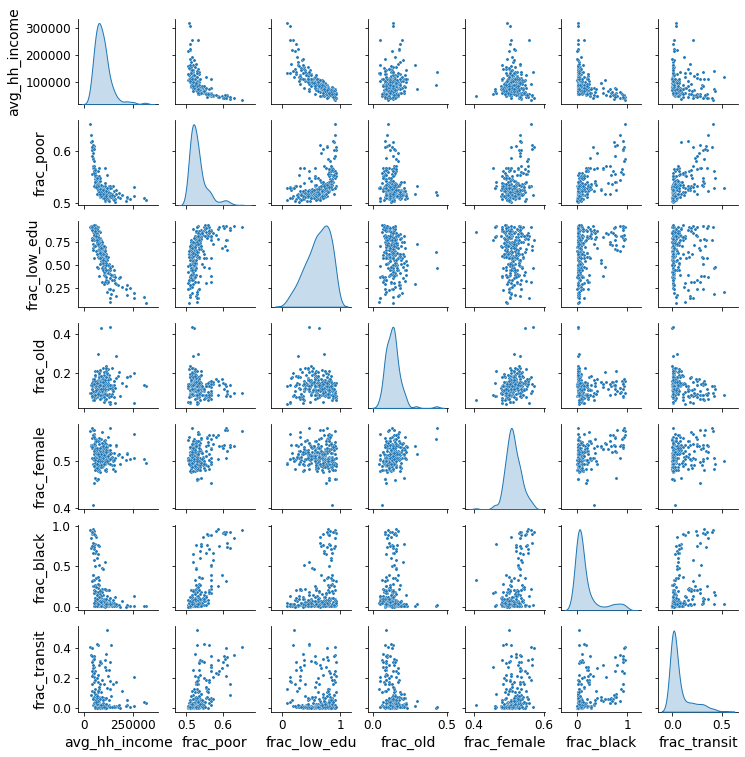

In [29]:
sns.pairplot((chi.acs_zip
              [['avg_hh_income'] + g.VUL_VARS]),
              diag_kind='kde', height=1.5, plot_kws={'s': 10});

## Filter in-hospital POIs

### Read all U.S. POIs

In [30]:
%%time
POIS = g.load_all_pois().merge(pd.concat([c.imp_zips for c in cities]))
peek(POIS)

Shape: (307732, 8), Memory: 75.187 MB
CPU times: user 14.9 s, sys: 2.05 s, total: 17 s
Wall time: 27.7 s


poi_id                            location_name  street_address      city  \
0     3662                        Tenth Avenue Park     825 10th St  Rockford   
1  2726124  Rockford Day Nursery Early Learning Ctr   2323 S 6th St  Rockford   
2  4214757                     Illinois Title Loans  923 E State St  Rockford   

     zip   latitude  longitude  parent_poi_id  
0  61104  42.255103 -89.085241            NaN  
1  61104  42.242128 -89.082270      4328921.0  
2  61104  42.266561 -89.082567            NaN

In [31]:
ALL_NAICS = g.load_all_naics()
peek(ALL_NAICS)

Shape: (2193, 2), Memory: 0.224 MB


naics                                 naics_title
0     11  Agriculture, Forestry, Fishing and Hunting
1    111                           Crop ProductionT 
2   1111                   Oilseed and Grain Farming

### Remove in-hospital POIs

In [32]:
(
POIS.merge(nyc.pois['naics'], on='poi_id')
[['poi_id', 'parent_poi_id']]
.rename(columns={'poi_id': 'child_id', 'parent_poi_id': 'parent_id'})
.merge(nyc.pois['naics'], left_on='parent_id', right_index=True)
.rename(columns={'naics': 'parent_naics'})
.astype({'parent_id': np.int32})
.merge(ALL_NAICS, left_on='parent_naics', right_on='naics')
.groupby(['naics', 'naics_title']).size().sort_values(ascending=False)
)

naics   naics_title                                                 
611110  Elementary and Secondary Schools                                1688
531120  Lessors of Nonresidential Buildings (except Miniwarehouses)     1300
712190  Nature Parks and Other Similar Institutions                      576
713910  Golf Courses and Country Clubs                                   355
447110  Gasoline Stations with Convenience Stores                        355
622110  General Medical and Surgical Hospitals                           188
711211  Sports Teams and Clubs                                            53
713110  Amusement and Theme Parks                                         47
611310  Colleges, Universities, and Professional Schools                  45
713210  Casinos (except Casino Hotels)                                    34
611210  Junior Colleges                                                   26
611519  Other Technical and Trade Schools                                 23
922140 

In [33]:
def filter_in_naics_pois(city, all_pois=POIS, filt_naics=[622110]):
    """
    Get the list of POIs that lie within another POI which lies in a given
    list of NAICS codes. For the analysis here, only in-hospital (#622110)
    POIs are excluded.
    """
    # get the mapping between 
    child2parent = (
        all_pois.merge(city.pois['naics'], on='poi_id')
        [['poi_id', 'parent_poi_id']]
        .rename(columns={'poi_id': 'child_id', 'parent_poi_id': 'parent_id'})
        .merge(city.pois['naics'], left_on='parent_id', right_index=True)
        .rename(columns={'naics': 'parent_naics'})
        .astype({'parent_id': np.int32})
    )
    # filter the POIs whose parent has NAICS in one of the filt_naics
    if filt_naics is not None:
        child2parent = (child2parent.pipe(lambda x: x[
            x['parent_naics'].isin(filt_naics)]))
    
    return child2parent

In [34]:
for c in cities:
    c.in_hosp_pois = (filter_in_naics_pois(c, filt_naics=[622110])
                      ['child_id'].values)

In [35]:
nyc.pois.loc[nyc.in_hosp_pois].merge(g.IMP_NAICS, on='naics').groupby('naics').size()

naics
445110     2
624410     7
722511    11
722513     6
722515     1
dtype: int64

## Mobility processing

### Calc. total dwell time

In [36]:
# add the columns for visits & total dwell times with 4 and 5 bins
for c in cities:
    if not 'visits5' in c.pat.columns:
        c.pat['visits5'] = c.pat['visits']
        del c.pat['visits']
    c.pat['visits4'] = c.pat[g.DWELL_BINS['names'][:4]].sum(1)
    c.pat['tot_dwell5'] = (c.pat[g.DWELL_BINS['names']].values @
                           g.DWELL_BINS['avg'])
    c.pat['tot_dwell4'] = (c.pat[g.DWELL_BINS['names'][:4]].values @
                           g.DWELL_BINS['avg'][:4])
    c.pat = c.pat.astype({'visits4': np.int32, 'visits5': np.int32,
                          'tot_dwell4': np.int32, 'tot_dwell5': np.int32})

### Join pat_od with pat & expand

In [37]:
def join_pat_pat_od(city, inc_bin_var='hh_inc_bin'):
    """
    Join the POI patterns data with the patterns OD matrix for faster
    downstream analysis.
    """
    pat = (city.pat
           .rename(columns={'visitors': 'poi_visitors', 'zip': 'poi_zip'})
           .drop(columns=['cnty']))
    od_zip = (city.od_zip
              .rename(columns={'date': 'week', 'zip': 'home_zip',
                               'visitors': 'home_visitors'}))
    joined = pat.merge(od_zip, on=('row_id', 'week')).drop(columns='row_id')
    return joined

In [38]:
%%time
for c in tqdm(cities):
    c.odX = join_pat_pat_od(c).rename(columns={'zip': 'poi_zip'})
peek(nyc.odX)


Shape: (20599696, 20), Memory: 1493.050 MB
CPU times: user 1min 2s, sys: 1min 27s, total: 2min 29s
Wall time: 2min 50s


poi_id  poi_visitors  med_dwell    week   naics  poi_zip  0-5  5-20  20-60  \
0   49434           406       76.0  200106  721110    10036    8   127    120   
1   49434           406       76.0  200106  721110    10036    8   127    120   
2   49434           406       76.0  200106  721110    10036    8   127    120   

   60-240  >240  exp_visits     tot_cei       cei  visits5  visits4  \
0     171   133         537  319.759674  0.595456      559      426   
1     171   133         537  319.759674  0.595456      559      426   
2     171   133         537  319.759674  0.595456      559      426   

   tot_dwell5  tot_dwell4  home_zip  home_visitors  
0       63977       32057      1701              4  
1       63977       32057      6340              4  
2       63977       32057      7087              4

### Get indices for quick filtering odX

In [40]:
%%time
for c in tqdm(cities):
    print(c.name)
    # mark rows True whose POIs lie in zip codes with case data
    c.odX['imp_zip'] = False
    c.odX.loc[(c.odX['poi_zip'].isin(c.imp_zips)) &
              (c.odX['home_zip'].isin(c.imp_zips)), 'imp_zip'] = True
    
    # mark rows whose POIs lie within hospital
    c.odX['out_hosp'] = True
    c.odX.loc[c.odX['poi_id'].isin(c.in_hosp_pois), 'out_hosp'] = False
    
    # mark rows whose POIs lie in imp_zips & are NOT within hospitals
    c.odX['imp_zip_out_hosp'] = False
    c.odX.loc[(c.odX['imp_zip']==True) & (c.odX['out_hosp']==True),
              'imp_zip_out_hosp'] = True

NYC
Illinois

CPU times: user 55.3 s, sys: 17 s, total: 1min 12s
Wall time: 1min 15s


In [151]:
%time chi.odX = il.odX[(il.odX['poi_zip'].isin(chi.zips)) & (il.odX['home_zip'].isin(chi.zips))]

CPU times: user 38.5 s, sys: 15.4 s, total: 53.9 s
Wall time: 1min 8s


### Filter the zips having case data

In [41]:
"""
Filter the relevant data of a city pertaining to only the zip areas where
health data is available. This is a crucial step because it may greatly
influence the downstream analysis. This step may be skipped to assess the
difference in results between important and all zip codes.
Also optionally skip POIs that lie inside hospitals.
"""
def get_pois(city, imp_zips=False, exclude_in_hosp=True):
    if not imp_zips:
        pois = city.pois
    else:
        pois = city.pois.reset_index().merge(city.imp_zips).set_index('poi_id')
    if exclude_in_hosp:
        pois = pois[~pois.index.isin(city.in_hosp_pois)]
    return pois

def get_acs_zip(city, imp_zips=False):
    if not imp_zips:
        return city.acs_zip
    else:
        acs = city.acs_zip.merge(city.imp_zips, on='zip')
        acs['inc_bin'] = pd.qcut(acs['avg_income'], g.INC_NBINS)
        acs['hh_inc_bin'] = pd.qcut(acs['avg_hh_income'], g.INC_NBINS)
        acs['inc_q'] = acs['inc_bin'].cat.codes + 1
        acs['hh_inc_q'] = acs['hh_inc_bin'].cat.codes + 1
        acs = acs.set_index('zip')
        return acs

def get_pat(city, imp_zips=False, out_hosp=True):
    if not imp_zips:
        pat = city.pat
    else:
        pat = city.pat.merge(city.imp_zips, on='zip')
    if out_hosp:
        pat = pat[~pat['poi_id'].isin(city.in_hosp_pois)]
    return pat

def get_od_zip(city, imp_zips=False):
    if not imp_zips:
        return city.od_zip
    return city.od_zip.merge(city.imp_zips, on='zip')
    
def get_odX(city, imp_zips=False, out_hosp=True):
    odX = city.odX
    if imp_zips and out_hosp:
        odX = odX[odX['imp_zip_out_hosp'] == True]
    else:
        if imp_zips:
            odX = odX[odX['imp_zip'] == True]
        if out_hosp:
            odX = odX[odX['out_hosp'] == True]
    return odX

In [42]:
peek(get_acs_zip(nyc, True), top=2)

Shape: (170, 16), Memory: 0.018 MB


tot_pop  tot_hh  tot_income  tot_hh_income    avg_income  \
zip                                                               
10001    43898   23989  4289277400     4128960500  97710.087020   
10002    82015   34984  2355576600     2173147800  28721.290008   

       avg_hh_income                  inc_bin                hh_inc_bin  \
zip                                                                       
10001  172118.908666  (43789.159, 143009.677]  (100869.174, 310580.327]   
10002   62118.334096   (25724.146, 32300.309]     (59109.18, 72032.337]   

       inc_q  hh_inc_q  frac_poor  frac_low_edu  frac_old  frac_female  \
zip                                                                      
10001      5         5   0.532339      0.278937  0.112351     0.480204   
10002      3         2   0.590742      0.676851  0.183783     0.522478   

       frac_black  frac_transit  
zip                              
10001    0.074195      0.449564  
10002    0.090800      0.547970

In [43]:
peek(get_pat(nyc, True))

Shape: (1050021, 20), Memory: 76.105 MB


row_id  poi_id  visitors  med_dwell    week   cnty   naics    zip  0-5  \
0       0   49434       406       76.0  200106  36061  721110  10036    8   
1       0   49434       439       87.0  200113  36061  721110  10036   10   
2       0   49434       257       83.0  200120  36061  721110  10036    4   

   5-20  20-60  60-240  >240  exp_visits     tot_cei       cei  visits5  \
0   127    120     171   133         537  319.759674  0.595456      559   
1   111    100     206   149         539  424.211426  0.787034      576   
2    79     69     127    86         328  144.351334  0.440096      365   

   visits4  tot_dwell5  tot_dwell4  
0      426       63977       32057  
1      427       72072       36312  
2      279       43447       22807

In [44]:
peek(get_od_zip(nyc, True))

Shape: (6344337, 4), Memory: 145.210 MB


row_id    week    zip  visitors
0       0  200106  10001         4
1       0  200224  10001         4
2       0  200427  10001         4

In [45]:
%time peek(get_odX(nyc, True))

Shape: (14983463, 23), Memory: 1128.858 MB
CPU times: user 1.49 s, sys: 2.09 s, total: 3.58 s
Wall time: 5.17 s


poi_id  poi_visitors  med_dwell    week   naics  poi_zip  0-5  5-20  \
14   49434           406       76.0  200106  721110    10036    8   127   
15   49434           406       76.0  200106  721110    10036    8   127   
16   49434           406       76.0  200106  721110    10036    8   127   

    20-60  60-240  ...       cei  visits5  visits4  tot_dwell5  tot_dwell4  \
14    120     171  ...  0.595456      559      426       63977       32057   
15    120     171  ...  0.595456      559      426       63977       32057   
16    120     171  ...  0.595456      559      426       63977       32057   

    home_zip  home_visitors  imp_zip  out_hosp  imp_zip_out_hosp  
14     10001              4     True      True              True  
15     10002              4     True      True              True  
16     10010              4     True      True              True  

[3 rows x 23 columns]

### Aggregate comparison of pat with expanded pat_od

In [46]:
%%time
def compare_odx_with_pat(city, imp_zips=True):
    """
    Compare the aggregate level measures of a city's POI patterns table (where
    each row is (POI, week)) with the pat OD extended table (odx) (each row is
    (POI, week, home zip)).
    """
    print('Comparing no. of items of weeks, POIs & week-POIs in pat and odx tables')
    for grp_var in ['week', 'poi_id', ['week', 'poi_id']]:
        print(f'pat: {grp_var}', get_pat(city, imp_zips).groupby(grp_var).size().size)
        print(f'odx: {grp_var}', get_odX(city, imp_zips).groupby(grp_var).size().size)
    
compare_odx_with_pat(nyc, True)

Comparing no. of items of weeks, POIs & week-POIs in pat and odx tables
pat: week 25
odx: week 25
pat: poi_id 63457
odx: poi_id 63240
pat: ['week', 'poi_id'] 1050021
odx: ['week', 'poi_id'] 1040283
CPU times: user 7 s, sys: 2.19 s, total: 9.2 s
Wall time: 9.22 s


### Get top specific industry dwellers

In [47]:
def get_top_dweller_pois(city, week, naics, all_pois=POIS, out_hosp=True):
    pat = (get_pat(city, imp_zips=True, out_hosp=out_hosp)
           .query(f'naics == {naics}')
           .query('week == {}'.format(week[2:].replace('-', '')))
           [['poi_id'] + g.DWELL_BINS['names'] + ['visits5', 'tot_dwell5']]
           .assign(avg_dwell5 = lambda x: x['tot_dwell5']/x['visits5'])
          )
    pat = (all_pois.merge(pat, on='poi_id')
           .sort_values('tot_dwell5', ascending=False)
           .reset_index(drop=True))
        
    return pat

In [48]:
(get_top_dweller_pois(nyc, '2020-03-23', 722513, out_hosp=False).head(10)
 [['location_name', 'city', 'tot_dwell5', 'parent_poi_id'] + g.DWELL_BINS['names']])

location_name      city  tot_dwell5  parent_poi_id  0-5  5-20  \
0                Au Bon Pain  Brooklyn      158852      1575069.0   10   179   
1                Au Bon Pain  New York       93570      2134234.0    7    93   
2                Au Bon Pain  New York       88650      1301786.0   10   114   
3     Krispy Krunchy Chicken     Bronx       50655            NaN    8   114   
4             Bluestone Lane  New York       34535            NaN    5    69   
5     Krispy Krunchy Chicken     Bronx       30807            NaN    5    50   
6     239 International Deli     Bronx       28875            NaN    5    53   
7          Metro Finest Deli  Brooklyn       27547            NaN    8   135   
8  Popeyes Louisiana Kitchen  Brooklyn       25222            NaN   12    93   
9             Little Caesars  Brooklyn       22190            NaN    9    75   

   20-60  60-240  >240  
0    197     281   444  
1     89     173   262  
2    116     160   244  
3     28      55   166  
4     30      66    94  
5     29      35    99  
6     27      48    83  
7     22      32    84  
8     36      37    71  
9     35      57    47

---
# Visualization

## Static

### Zips map

In [49]:
def plot_map_zips(city, cntys=None, cbgs=True, epsg=4326, figsize=(10, 10)):
    """
    Plot the map of the zip areas and see how they are different from CBGs
    (overlaps). Use either all zips or only the ones with the case data
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')
    zip_df = city.shp_zip.copy()
    if cntys is not None:
        cnty_df = (city.shp_cnty.astype({'COUNTYFP': int})
                   .pipe(lambda x: x[x['COUNTYFP'].isin(cntys)]))
        cbg_df = (city.shp_cbg.astype({'countyfp': int})
                  .pipe(lambda x: x[x['countyfp'].isin(cntys)]))
    else:
        cnty_df = city.shp_cnty
        cbg_df = city.shp_cbg
    zip_df.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5)
    cnty_df.plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=1.5)
    if cbgs:
        cbg_df.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=.2)

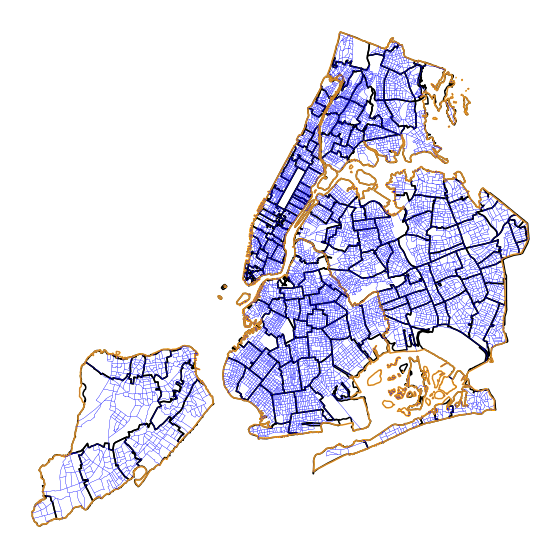

In [50]:
plot_map_zips(nyc, cntys=[61, 5, 81, 47, 85])

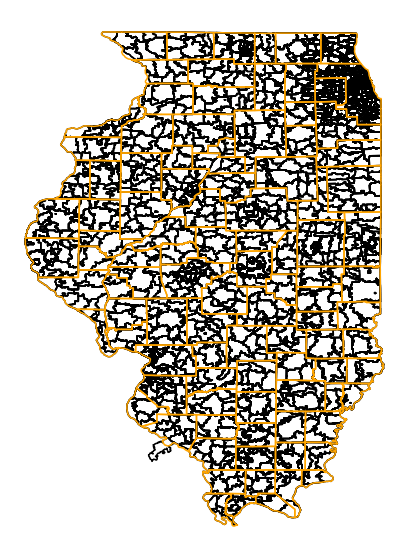

In [51]:
plot_map_zips(il, cbgs=False)

In [52]:
def plot_map_cases(city, cntys=None, epsg=4326, figsize=(10, 10)):
    """
    Plot the map of cases by zip code.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')
    zip_df = city.shp_zip.copy()
    if cntys is not None:
        cnty_df = (city.shp_cnty.astype({'COUNTYFP': int})
                   .pipe(lambda x: x[x['COUNTYFP'].isin(cntys)]))
        cbg_df = (city.shp_cbg.astype({'countyfp': int})
                  .pipe(lambda x: x[x['countyfp'].isin(cntys)]))
    else:
        cnty_df = city.shp_cnty
        cbg_df = city.shp_cbg
    zip_df.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5)
    cnty_df.plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=1.5)
    cbg_df.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=.2)

### Population composition by income

In [53]:
def plot_pie_by_inc_class(city, var='tot_pop', imp_zips=True, inc_bin_var='hh_inc_bin'):
    """
    Plot the pie chart of an extensive measure by city's income classes.
    """
    # get the zip-level census data
    acs = get_acs_zip(city, imp_zips)
    
    df = acs.groupby(inc_bin_var)[var].sum()
    colors = sns.color_palette(g.CMAPS['income_classes'], g.INC_NBINS)
    labels = [f'{x.left/1e3:.0f}k - {x.right/1e3:.0f}k' for x in df.index.tolist()]
    df.plot(kind='pie', colors=colors, labels=labels,
            autopct='%.1f%%', startangle=90)
    plt.ylabel('')

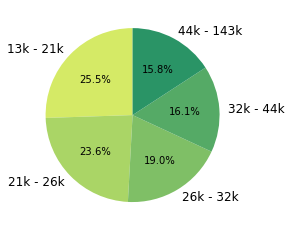

In [54]:
plot_pie_by_inc_class(nyc, var='tot_pop', inc_bin_var='inc_bin')

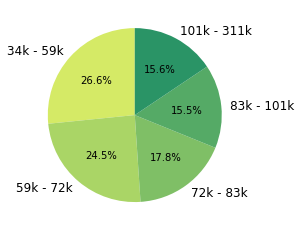

In [55]:
plot_pie_by_inc_class(nyc, var='tot_pop', inc_bin_var='hh_inc_bin')

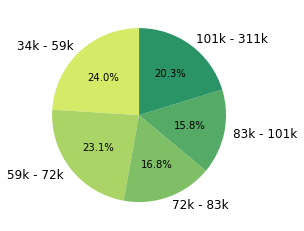

In [56]:
plot_pie_by_inc_class(nyc, var='tot_hh', inc_bin_var='hh_inc_bin')

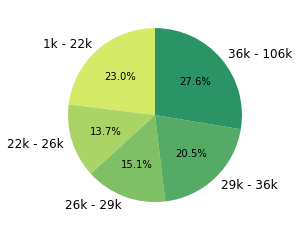

In [57]:
plot_pie_by_inc_class(il, var='tot_pop', inc_bin_var='inc_bin')

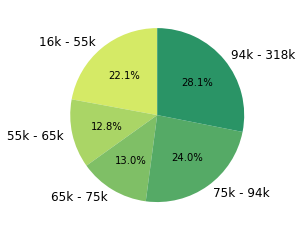

In [58]:
plot_pie_by_inc_class(il, var='tot_pop', inc_bin_var='hh_inc_bin')

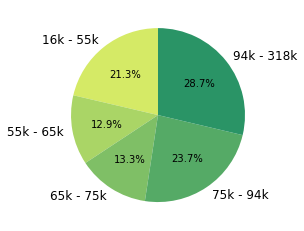

In [59]:
plot_pie_by_inc_class(il, var='tot_hh', inc_bin_var='hh_inc_bin')

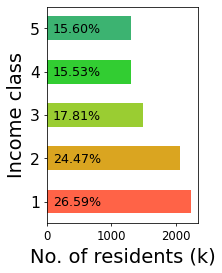

In [199]:
def plot_popu_by_inc_class(city, var='tot_pop', imp_zips=True,
                           inc_bin_q='hh_inc_q', dpi=70):
    # get the zip-level census data
    acs = get_acs_zip(city, imp_zips)
    vals = acs.groupby(inc_bin_q)[var].sum()/1e3
    vals = pd.concat([vals, (vals/vals.sum()).rename('proportion')], axis=1)
    inc_q_map = {1:2,2:4,3:3,4:1,5:5}
    # plot
    fig, ax = plt.subplots(figsize=(2.8, 4.1), dpi=dpi)
    plt.barh(vals.index, vals[var], color=g.COLORS['income_classes5'],
             height=0.55)
    plt.ylabel('Income class', fontsize=20)
    plt.yticks(fontsize=16)
#     plt.title('Population income\n distribution', fontsize=18)
    plt.xlabel('No. of residents (k)', fontsize=20)
    for i, v in enumerate(vals['proportion']):
        ax.text(v+100, i+0.9, f'{v*100:.2f}%', color='k', fontsize=13)
    return inc_q_map

_ = plot_popu_by_inc_class(nyc, dpi=70)

### POI visitors to visits ratio

In [61]:
def plot_visit_visitor_ratio(city, imp_zips=True):
    """
    Plot the trend of ratio of visits to visitors to POIs of a city.
    """
    ratios = (get_pat(city, imp_zips)
              .groupby(['week'])
              [['visits5', 'visitors']].sum()
              .reset_index()
              .assign(ratio = lambda x: x['visits5']/x['visitors'],
                      week = lambda x: g.int2date(x['week']))
              .set_index('week')['ratio']
             )
    ratios.plot(marker='o')
    plt.title('Ratio of total POI visits to total visitors in '+
              city.name)
    plt.ylabel('Visits/Visitors')
    plt.xlabel('')

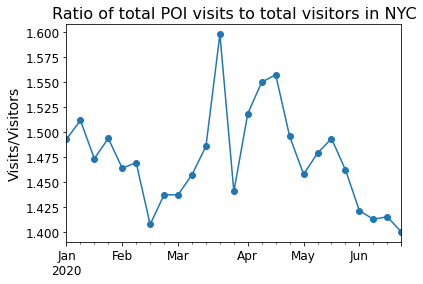

In [62]:
plot_visit_visitor_ratio(nyc)

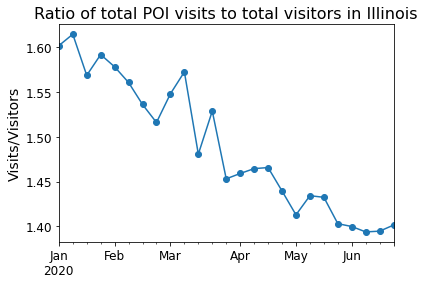

In [63]:
plot_visit_visitor_ratio(il)

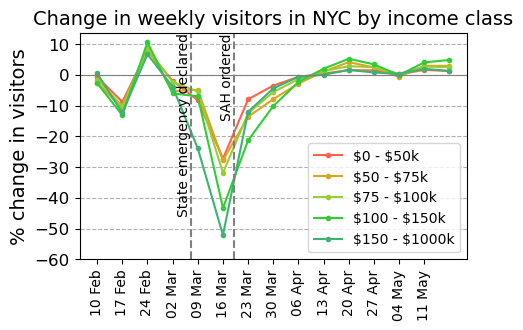

In [64]:
def plot_trend_mob_by_income(dpi=70):
    bins = [0, 50, 75, 100, 150, 1000]
    inc = (pd.cut((nyc.acs['avg_hh_income']/1e3).dropna(),
                  bins)).rename('inc_bin')
    res = (get_pat(nyc, True)
           .merge(nyc.pois['cbg'], on='poi_id')
           .merge(inc, on='cbg')
           .assign(inc_q = lambda x: (x['inc_bin'].cat.codes+1).map(_))
           .query('inc_q > 0')
           .groupby(['inc_q', 'week'])
           ['visits5'].sum()
           .reset_index()
           .assign(week = lambda x: g.int2date(x['week']))
           .set_index('week')
           .pipe(lambda x: x[(x.index <= g.int2date(200520)) &
                             (x.index >= g.int2date(200130))]))
    fig, ax = plt.subplots(figsize=(5, 3), dpi=dpi)
    colors = g.COLORS['income_classes5']
    labels = {i+1: f'\${bins[i]} - \${bins[i+1]}k' for i in range(len(bins)-1)}
    plt.xticks(pd.date_range('2020-02-03', '2020-05-11', freq='7D'),
               rotation=90, fontsize=10)
    for i, (inc_q, df) in enumerate(res.groupby('inc_q')):
        ax.plot((df['visits5']/1e6).diff()*100, color=colors[i],
                marker='.', label=labels[inc_q])
    plt.title('Change in weekly visitors in NYC by income class', fontsize=14)
    plt.legend(fontsize=10)
    plt.xlabel('')
    plt.ylabel('% change in visitors')
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d %b'))
    ax.set_yticks(np.arange(-60, 20, 10))
    ax.yaxis.grid(ls='--')
    ax.axhline(0, color='grey', lw=0.8)
    for evt, date in [('State emergency declared', 200307), ('SAH ordered', 200319)]:
        ax.axvline(g.int2date(date), color='grey', ls='--')
        ax.text(g.int2date(date), ax.get_ylim()[1], evt, ha='right', va='top',
                rotation=90)
#     return res
plot_trend_mob_by_income(dpi=100)

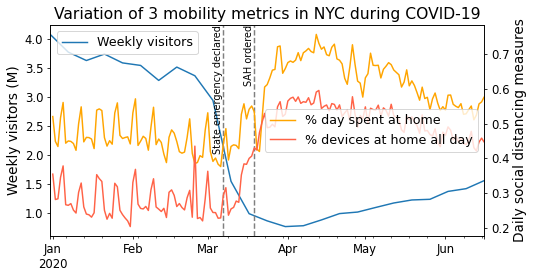

In [65]:
def plot_mob_trend(city):
    fig, ax1 = plt.subplots(figsize=(8, 4), dpi=70)
    ax2 = ax1.twinx()
    (city.sd
     .assign(tot_time_home = lambda x: x['tot_dev']*x['time_home'])
     .groupby('date').sum()
     .assign(time_home = lambda x: x['tot_time_home']/x['tot_dev']/24,
             prop_home = lambda x: x['dev_home']/x['tot_dev'])
     [['time_home', 'prop_home']]
     .plot(ax=ax2, color=['orange', 'tomato'])
    )
    ax2.legend(labels=['% day spent at home', '% devices at home all day'],
               loc='center right')
    ((city.pat.groupby('week')['visitors'].sum()/1e6)
     .reset_index()
     .assign(week = lambda x: g.int2date(x['week']))
     .set_index('week')
     .plot(ax=ax1, label='Visitors')
    )
    for evt, date in [('State emergency declared', 200307), ('SAH ordered', 200319)]:
        ax1.axvline(g.int2date(date), ls='--', color='grey')
        ax1.text(g.int2date(date), ax1.get_ylim()[1], evt, color='k',
                 ha='right', va='top', rotation=90)
    ax1.legend(labels=['Weekly visitors'], loc='upper left')
    ax1.set_xlabel('')
    ax1.set_ylabel('Weekly visitors (M)')
    ax2.set_ylabel('Daily social distancing measures')
    plt.title('Variation of 3 mobility metrics in NYC during COVID-19')
    
plot_mob_trend(nyc)

### POI visits by income

In [66]:
def get_poi_vis_by_poi_inc(city, var='visits5', imp_zips=True, plot=False):
    """
    Get the weekly visits or visitors to the POIs totalled by the income class
    of the zip code in which the POI lies.
    @param var: <str> POI-based measure of mobility (either `poi_visits` or
    `poi_visitors`)
    @param imp_zip: whether include only the zips with cases data
    """
    # get the expanded zip OD matrix (with POI attrs) & get its income
    res = (get_odX(city, imp_zips)
           .merge(city.acs_zip['hh_inc_q'], left_on='poi_zip', right_index=True)
           .rename(columns={'hh_inc_q': 'poi_inc_q'})
           .groupby(['week', 'poi_id', 'poi_inc_q'])
           [[var]].first()
           .groupby(['week', 'poi_inc_q'])
           .sum()
           .reset_index()
           .assign(week = lambda x: g.int2date(x['week'], fmt='%y%m%d'))
           .set_index('week')
          )
    if plot:
        fig, ax = plt.subplots()
        colors = sns.color_palette(g.CMAPS['income_classes'], g.INC_NBINS)
        for (bin_, df), col in zip(res.groupby('poi_inc_q'), colors):
            (df[var]/1e3).plot(ax=ax, color=col, label=f'Q{bin_}')
        plt.xlabel('')
        ylabel = ''
        if var == 'visits5': ylabel = 'Visits (k)'
        if var == 'visitors': ylabel = 'Visitors (k)'
        plt.ylabel(ylabel)
        plt.title(f'Weekly {var} by income quintile\n' +
                  'of POI zip in ' + city.name);
        plt.legend()
    return res

CPU times: user 9.82 s, sys: 4.74 s, total: 14.6 s
Wall time: 14.7 s


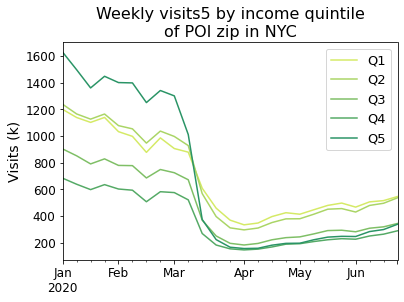

In [67]:
%time _ = get_poi_vis_by_poi_inc(nyc, plot=True);

CPU times: user 9.31 s, sys: 3.65 s, total: 13 s
Wall time: 13 s


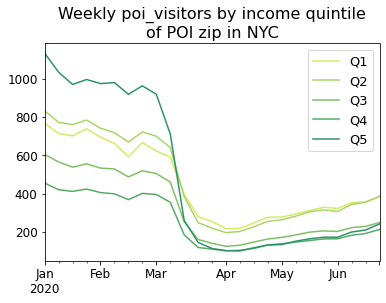

In [68]:
%time _ = get_poi_vis_by_poi_inc(nyc, var='poi_visitors', plot=True);

<b>Inference</b>: More people come to richer POIs than poorer POIs.

<b>Inference</b>: More people come to richer POIs than poorer POIs.

### Home visitors by income

In [69]:
def get_poi_vis_by_home_inc(city, imp_zips=True, plot=False):
    """
    Get the weekly visits to the POIs totalled by the income class of the zip
    code in which the POI lies.
    """
    res = (get_odX(city, imp_zips)
           .merge(city.acs_zip['hh_inc_q'].rename('home_inc_q'),
                  left_on='home_zip', right_index=True)
           .groupby(['week', 'home_inc_q'])
           ['home_visitors'].sum()
           .reset_index()
           .assign(week = lambda x: g.int2date(x['week'], fmt='%y%m%d'))
           .set_index('week')
          )
    if plot:
        fig, ax = plt.subplots()
        colors = sns.color_palette(g.CMAPS['income_classes'], g.INC_NBINS)
        for (bin_, df), col in zip(res.groupby(['home_inc_q']), colors):
            (df['home_visitors']/1e6).plot(ax=ax, color=col, label=f'Q{bin_}')
        plt.xlabel('')
        plt.ylabel('Visitors (M)')
        plt.legend()
        plt.title('Weekly home visitors by income\n' +
                  'quintile of home zip in ' + city.name);
    return res

CPU times: user 12.8 s, sys: 2.97 s, total: 15.8 s
Wall time: 15.9 s


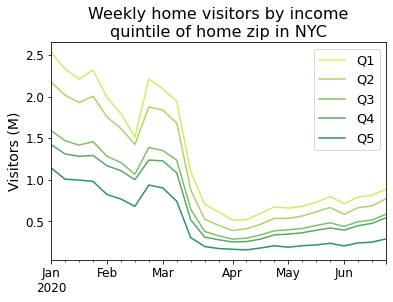

In [70]:
%time _ = get_poi_vis_by_home_inc(nyc, plot=True)

<b>Inference</b>: Fewer rich people travel compared to poorer people, both before & after lockdown.

<b>Inference</b>: Fewer rich people travel compared to poorer people, both before & after lockdown.

## Dwell-time visualization

### Dwell time by POI zip income

### Dwell time by home zip income

In [71]:
def get_dwell_by_home_inc(city, imp_zips=True, nbins=5,
                          imp_naics=False, plot=False):
    """
    Get the weekly trend of average dwell time over income class of home
    visitors.
    @param imp_naics: whether filter the OD data for only the important naics
    """
    # get the expanded patterns OD matrix
    odX = get_odX(city, imp_zips)
    # filter the NAICS, if required
    odX = odX[odX['naics'].isin(g.IMP_NAICS.index)] if imp_naics else odX
        
    # first get the no. of home visitors by POI & home zip income class
    res = (odX.rename(columns={f'tot_dwell{nbins}': 'tot_dwell'})
           .merge(city.acs_zip['hh_inc_q'].rename('home_inc_q'),
                  left_on='home_zip', right_index=True)
           .groupby(['week', 'poi_id', 'home_inc_q'])
           .agg({'tot_dwell': 'first', 'home_visitors': sum})
           .reset_index('home_inc_q')
          )
    # calculate the total home visitors of each POI
    tot_vis_by_poi = (res.groupby(['week', 'poi_id'])
                      ['home_visitors'].sum()
                      .rename('tot_home_visitors')
                     )
    # now distribute the POI total dwell time into its income class components
    # in proportion of the home visitors in its income classes
    res = (res
           .merge(tot_vis_by_poi, on=('week', 'poi_id'))
           .astype({'tot_dwell': float, 'home_visitors': int,
                    'tot_home_visitors': float})
           .assign(tot_dwell_inc = lambda x:
                   x['tot_dwell']*x['home_visitors']/x['tot_home_visitors'])
           .drop(columns=['tot_dwell'])
           .rename(columns={'tot_dwell_inc': 'tot_dwell'})
           .groupby(['week', 'home_inc_q'])
           .sum()
           .assign(avg_dwell = lambda x: x['tot_dwell']/x['home_visitors'])
           .drop(columns=['tot_dwell', 'tot_home_visitors'])
           .reset_index()
           .assign(week = lambda x: g.int2date(x['week']))
           .set_index('week')
          )
    if plot:
        fig, ax = plt.subplots()
        colors = sns.color_palette(g.CMAPS['income_classes'], g.INC_NBINS)
        for (bin_, df), col in zip(res.groupby(['home_inc_q']), colors):
            (df['avg_dwell']).plot(ax=ax, color=col, label=f'Q{bin_}')
        plt.xlabel('')
        plt.ylabel('Dwell time (min)')
        plt.legend()
        plt.title(f'Weekly avg. dwell time ({nbins} bins) by income\n' +
                  'quintile of home zip in ' + city.name);
    return res

CPU times: user 19.3 s, sys: 4.86 s, total: 24.2 s
Wall time: 24.4 s


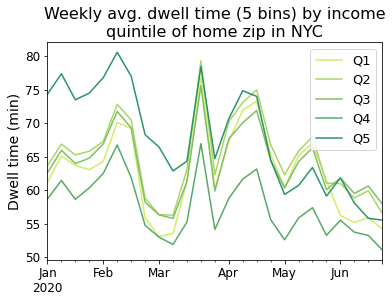

In [72]:
%time _ = get_dwell_by_home_inc(nyc, plot=True)

CPU times: user 12.4 s, sys: 3 s, total: 15.4 s
Wall time: 15.6 s


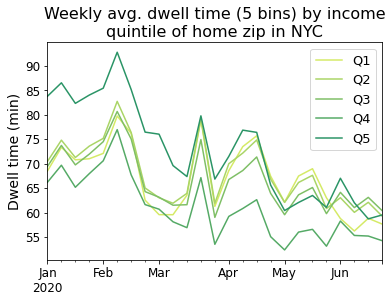

In [73]:
%time _ = get_dwell_by_home_inc(nyc, imp_naics=True, plot=True)

CPU times: user 19.9 s, sys: 5.84 s, total: 25.7 s
Wall time: 25.9 s


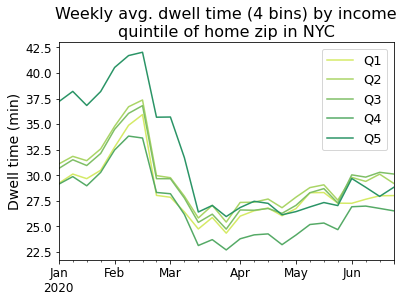

In [74]:
%time _ = get_dwell_by_home_inc(nyc, nbins=4, plot=True)

CPU times: user 12 s, sys: 2.86 s, total: 14.8 s
Wall time: 14.9 s


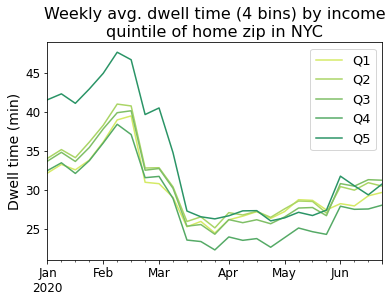

In [75]:
%time _ = get_dwell_by_home_inc(nyc, nbins=4, imp_naics=True, plot=True)

### Dwell time by industry

In [76]:
def get_vis_by_dwell_naics(city, imp_zips=True):
    """
    Calc. the total weekly POI visits by industry in different dwell time
    buckets.
    """
    res = (get_pat(city, imp_zips)
           [['week', 'naics'] + g.DWELL_BINS['names']]
           .merge(g.IMP_NAICS['category'], on='naics')
           .drop(columns='naics')
           .groupby(['category', 'week'])
           .sum()
           .reset_index()
           .assign(week = lambda x: g.int2date(x['week']))
           .set_index(['category', 'week'])
          )
    return res

In [77]:
peek(get_vis_by_dwell_naics(nyc))

Shape: (300, 5), Memory: 0.014 MB


0-5    5-20   20-60  60-240    >240
category  week                                             
Bars/Pubs 2020-01-06  708.0  7138.0  5015.0  6764.0  4734.0
          2020-01-13  618.0  6391.0  4578.0  6390.0  4496.0
          2020-01-20  518.0  6137.0  4506.0  6293.0  4358.0

In [78]:
def plot_visits_by_naics_dwell_bin(city, imp_zips=True,
                                   pre_date=None, post_date=None):
    """
    Plot the trend of total weekly visits by dwell-time bucket and industry.
    @param pre_date, post_date: <str> dates to be considered representative
    of the pre-restriction and post-restriction era (must be a Monday)
    """
    data = get_vis_by_dwell_naics(city, imp_zips)
    fig, ax = plt.subplots(3, 4, figsize=(16, 9), dpi=60, sharex=True)
    ax = ax.flatten()
    for i, (cat, df) in enumerate(data.groupby('category')):
        ((df.reset_index('category', drop=True)/1e3)
         .plot(ax=ax[i], color=sns.color_palette(g.CMAPS['dwell_bins'], 5)))
        if i != 0:
            ax[i].legend().remove()
        ax[i].set_title('{} ({:.0f}k)'.format(cat, df.sum().mean()/1e3))
        
        # plot dates
        if pre_date is not None:
            ax[i].axvline(g.str2date(pre_date), color='grey')
        if post_date is not None:
            ax[i].axvline(g.str2date(post_date), color='grey')
    fig.suptitle('Weekly visits (k) by dwell time buckets across industry in ' +
                 city.name + '\n (all-time weekly average shown in parentheses)',
                 fontsize=20, y=0.98)
    plt.tight_layout()

CPU times: user 4.25 s, sys: 293 ms, total: 4.55 s
Wall time: 2.51 s


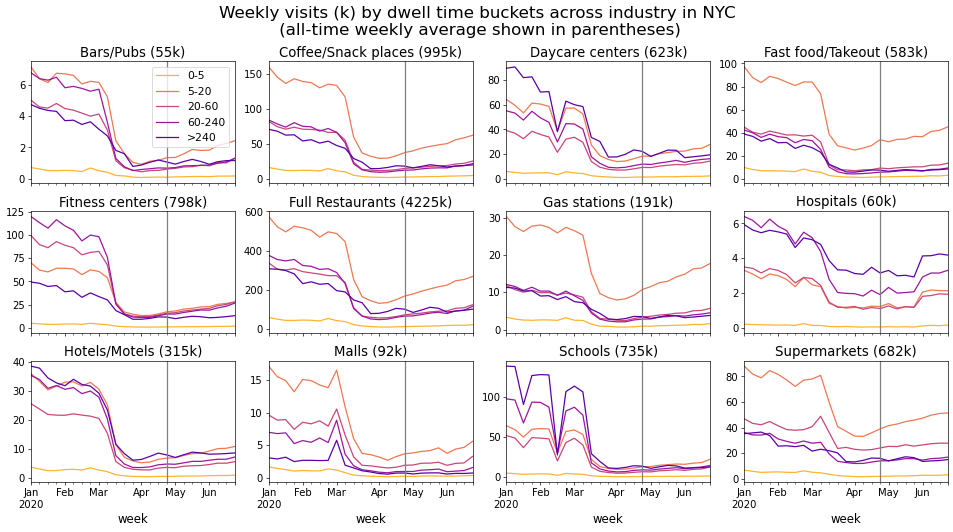

In [79]:
%time plot_visits_by_naics_dwell_bin(nyc, '2020-01-27', '2020-04-27')

### Dwell time distribution on a date

In [80]:
def get_dwell_distr_by_naics_on(city, date, imp_zips=True, plot=False):
    """
    Filter the discrete probability distribution of dwell time a city on a
    particular date by industry, used to compare the change in composition.
    """
    res = (get_vis_by_dwell_naics(city, imp_zips)
          .reset_index('category')
          .loc[g.str2date(date)]
          .set_index('category'))
    res = res.divide(res.sum(1), axis=0)
    
    if plot:
        fig, ax = plt.subplots(figsize=(5, 5))
        res.plot.barh(ax=ax, stacked=True, cmap=g.CMAPS['dwell_bins'])
        plt.legend(bbox_to_anchor=(1.01, 1))
        plt.ylabel('')
        plt.title('Dwell time composition by industry:\n{}, {}'
                  .format(city.name, g.str2date(date).strftime('%d %b')))
    
    return res

Shape: (12, 5), Memory: 0.001 MB


0-5      5-20     20-60    60-240      >240
category                                                             
Bars/Pubs            0.022477  0.295009  0.210358  0.283836  0.188319
Coffee/Snack places  0.032114  0.384382  0.198342  0.215813  0.169350
Daycare centers      0.019157  0.253738  0.159050  0.226239  0.341816

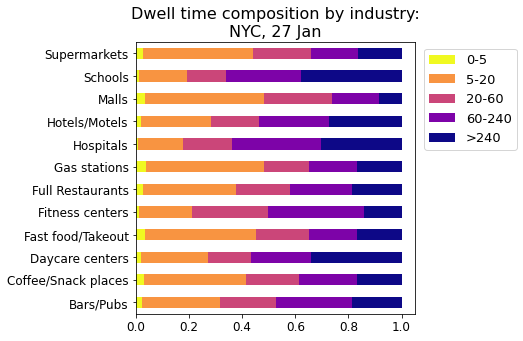

In [81]:
_ = get_dwell_distr_by_naics_on(nyc, '2020-01-27', plot=True)
peek(_)

### Change in dwell time distribution

In [82]:
def get_change_dwell_distr(city, b4_date, aft_date, plot=False):
    """
    Get the difference in the dwell time discrete probability distribution of a
    city between two dates by industry to see how dwell time buckets had
    different relative change in proportion of visits by industry.
    """
    # get the distributions on before and after dates
    b4_distr = get_dwell_distr_by_naics_on(city, b4_date)
    aft_distr = get_dwell_distr_by_naics_on(city, aft_date)
    # get the element wise difference to get change in percentage points
    res = (aft_distr - b4_distr) * 100
    
    if plot:
        fig, ax = plt.subplots(figsize=(5, 5))
        res.plot.barh(ax=ax, stacked=True, cmap=g.CMAPS['dwell_bins'])
        plt.legend(bbox_to_anchor=(1.01, 1))
        plt.ylabel('')
        plt.xlabel('Change in percentage points')
        plt.title('Change in dwell time composition in {} \n between {} and {}'
              .format(city.name, g.str2date(b4_date).strftime('%d %b'),
                      g.str2date(aft_date).strftime('%d %b')))
    return res

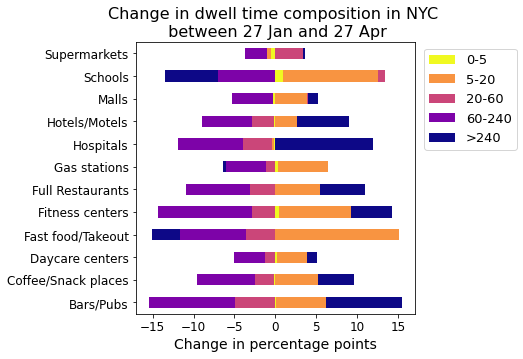

In [83]:
_ = get_change_dwell_distr(nyc, '2020-01-27', '2020-04-27', plot=True)

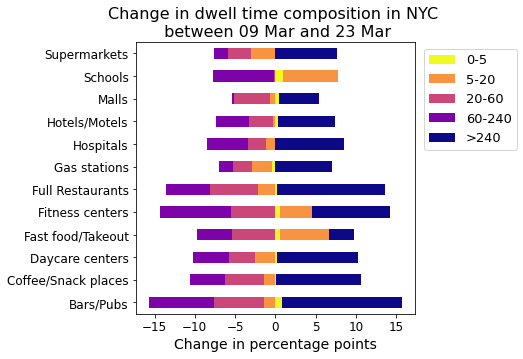

In [84]:
_ = get_change_dwell_distr(nyc, '2020-03-09', '2020-03-23', plot=True)

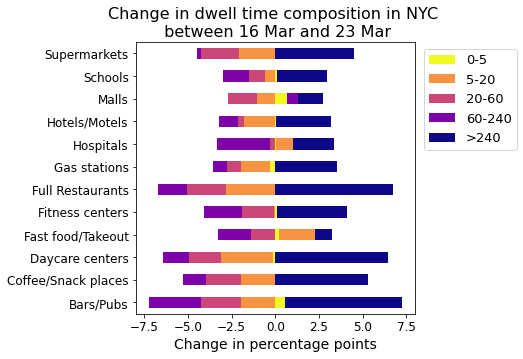

In [85]:
_ = get_change_dwell_distr(nyc, '2020-03-16', '2020-03-23', plot=True)

## Investigate dwell time

In [86]:
city = nyc

In [87]:
(nyc.pois.loc[nyc.in_hosp_pois]
 .query('naics == 722513')
 .merge(POIS.drop(columns=['zip']), on='poi_id')
 .merge(nyc.acs_zip['hh_inc_q'], on='zip')
 .rename(columns={'hh_inc_q': 'poi_income_q'})
 [['location_name', 'street_address', 'city', 'poi_income_q']]
)

location_name                                  street_address      city  \
0   Au Bon Pain  1400 Pelham Parkway South Store House Building  New York   
1   Au Bon Pain                                   7901 Broadway  Elmhurst   
2   Au Bon Pain                                     462 1st Ave  New York   
3   Au Bon Pain                                 2601 Ocean Pkwy  Brooklyn   

   poi_income_q  
0             2  
1             2  
2             5  
3             2

In [88]:
(get_pat(nyc, True, True)
 .query('naics == 722513 & week == 200330')
 .merge(nyc.acs_zip['hh_inc_q'], on='zip')
 [['poi_id', 'hh_inc_q', 'visits5', 'tot_dwell5']]
 .set_index('poi_id').sort_index()
).join(
    (get_odX(nyc, True, True)
    .query('naics == 722513 & week == 200330')
    .merge(nyc.acs_zip['hh_inc_q'], left_on='poi_zip', right_index=True)
    [['poi_id', 'hh_inc_q', 'visits5', 'tot_dwell5']]
    .groupby('poi_id').first().sort_index()
    ),
    lsuffix='_pat', rsuffix='_odX'
)

hh_inc_q_pat  visits5_pat  tot_dwell5_pat  hh_inc_q_odX  visits5_odX  \
poi_id                                                                          
8715                3           18             342           3.0         18.0   
9531                2           21            1957           2.0         21.0   
10506               5           18            1920           5.0         18.0   
10803               4           11            1122           4.0         11.0   
12602               4           93            3667           4.0         93.0   
...               ...          ...             ...           ...          ...   
5245485             5            9             320           5.0          9.0   
5255351             4           28             880           4.0         28.0   
5263510             1           21            3015           1.0         21.0   
5270458             2           13            1930           2.0         13.0   
5283156             5           21            2115           5.0         21.0   

         tot_dwell5_odX  
poi_id                   
8715              342.0  
9531             1957.0  
10506            1920.0  
10803            1122.0  
12602            3667.0  
...                 ...  
5245485           320.0  
5255351           880.0  
5263510          3015.0  
5270458          1930.0  
5283156          2115.0  

[799 rows x 6 columns]

In [89]:
%%time
(get_odX(nyc, True, True)
 .query('naics == 722513 & week == 200330')
 .merge(nyc.acs_zip['hh_inc_q'], left_on='poi_zip', right_index=True)
 [['poi_id', 'hh_inc_q', 'visits5', 'tot_dwell5']]
 .groupby('poi_id').first().sort_index()
)

CPU times: user 1.43 s, sys: 652 ms, total: 2.08 s
Wall time: 2.1 s


hh_inc_q  visits5  tot_dwell5
poi_id                                
8715            3       18         342
9531            2       21        1957
10506           5       18        1920
10803           4       11        1122
12602           4       93        3667
...           ...      ...         ...
5245485         5        9         320
5255351         4       28         880
5263510         1       21        3015
5270458         2       13        1930
5283156         5       21        2115

[793 rows x 3 columns]

CPU times: user 1.02 s, sys: 248 ms, total: 1.27 s
Wall time: 1.28 s


Text(0.5, 0, 'Income quintile of POI ZCTAs')

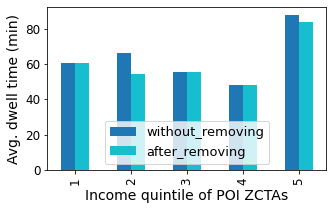

In [90]:
%%time
pd.concat([
    (get_pat(city, imp_zips=True, out_hosp=False)
     .pipe(lambda x: x[x.week == 200330])
     .merge(city.acs_zip['hh_inc_q'].rename('poi_inc_q'), on='zip')
     .merge(g.IMP_NAICS['category'], on='naics')
     .query('category == "Fast food/Takeout"')
     .groupby(['poi_inc_q', 'category'])
     .agg({'med_dwell': np.mean, 'visits5': sum, 'visits4': sum,'tot_dwell4': sum, 'tot_dwell5': sum})
     .assign(avg_dwell4 = lambda x: x['tot_dwell4']/x['visits4'],
             avg_dwell5 = lambda x: x['tot_dwell5']/x['visits5'])
     ['avg_dwell5'].reset_index()
     .drop(columns=['category'])
     .set_index('poi_inc_q')
     .rename(columns={'avg_dwell5': 'without_removing'})
    ),
    (get_pat(city, imp_zips=True, out_hosp=True)
     .pipe(lambda x: x[x.week == 200330])
     .merge(city.acs_zip['hh_inc_q'].rename('poi_inc_q'), on='zip')
     .merge(g.IMP_NAICS['category'], on='naics')
     .query('category == "Fast food/Takeout"')
     .groupby(['poi_inc_q', 'category'])
     .agg({'med_dwell': np.mean, 'visits5': sum, 'visits4': sum,'tot_dwell4': sum, 'tot_dwell5': sum})
     .assign(avg_dwell4 = lambda x: x['tot_dwell4']/x['visits4'],
             avg_dwell5 = lambda x: x['tot_dwell5']/x['visits5'])
     ['avg_dwell5'].reset_index()
     .drop(columns=['category'])
     .set_index('poi_inc_q')
     .rename(columns={'avg_dwell5': 'after_removing'})
    )
], axis=1).plot.bar(cmap='tab10', figsize=(5, 3))
plt.legend(loc='lower center')
plt.ylabel('Avg. dwell time (min)')
plt.xlabel('Income quintile of POI ZCTAs');

CPU times: user 3.05 s, sys: 1.31 s, total: 4.36 s
Wall time: 4.4 s


Text(0.5, 0, 'Income quintile of visitor ZCTAs')

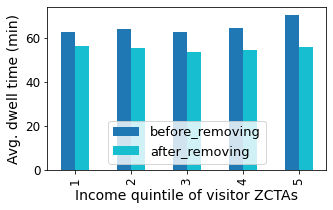

In [91]:
%%time
pd.concat([
(get_odX(city, True, out_hosp=False)
          .query('week == 200330')
          .merge(g.IMP_NAICS['category'], on='naics')
 .query('category == "Fast food/Takeout"')
          .merge(city.acs_zip['hh_inc_q'].rename('poi_inc_q'),
                 left_on='poi_zip', right_index=True)
          .merge(city.acs_zip['hh_inc_q'].rename('home_inc_q'),
                 left_on='home_zip', right_index=True)
          .groupby(['category', 'home_inc_q'])
          .agg({**{'med_dwell': np.mean}, **{x: sum for x in [
              'poi_visitors', 'visits4', 'visits5', 'tot_dwell4', 'tot_dwell5']}})
          .assign(avg_dwell4 = lambda x: x['tot_dwell4']/x['visits4'],
                  avg_dwell5 = lambda x: x['tot_dwell5']/x['visits5'])
          .drop(columns=['tot_dwell4', 'tot_dwell5'])
          ['avg_dwell5'].reset_index()
 .drop(columns='category')
 .set_index('home_inc_q')
 .rename(columns={'avg_dwell5': 'before_removing'})
),
(get_odX(city, True, out_hosp=True)
          .query('week == 200330')
          .merge(g.IMP_NAICS['category'], on='naics')
 .query('category == "Fast food/Takeout"')
          .merge(city.acs_zip['hh_inc_q'].rename('poi_inc_q'),
                 left_on='poi_zip', right_index=True)
          .merge(city.acs_zip['hh_inc_q'].rename('home_inc_q'),
                 left_on='home_zip', right_index=True)
          .groupby(['category', 'home_inc_q'])
          .agg({**{'med_dwell': np.mean}, **{x: sum for x in [
              'poi_visitors', 'visits4', 'visits5', 'tot_dwell4', 'tot_dwell5']}})
          .assign(avg_dwell4 = lambda x: x['tot_dwell4']/x['visits4'],
                  avg_dwell5 = lambda x: x['tot_dwell5']/x['visits5'])
          .drop(columns=['tot_dwell4', 'tot_dwell5'])
          ['avg_dwell5'].reset_index()
 .drop(columns='category')
 .set_index('home_inc_q')
 .rename(columns={'avg_dwell5': 'after_removing'})
)
], axis=1).plot.bar(cmap='tab10', figsize=(5, 3))
plt.legend(loc='lower center')
plt.ylabel('Avg. dwell time (min)')
plt.xlabel('Income quintile of visitor ZCTAs');

### By POI income

In [92]:
def dwell_by_naics_inc_on_date(city, date, measure='avg_dwell5',
                               imp_zips=True, out_hosp=True, plot=True):
    """
    Get the average dwell time on a specific date of different industries by
    income class of the POI zip.
    @param measure: <str> use one of these 3 measures to average dwell time:
        1. avg. of weekly median,
        2. avg. of 1st 4 bins,
        3. avg. of all bins with last bin = 240 min
    """
    # add the column for visits of dwell bin 5
    df = get_pat(city, imp_zips, out_hosp)
    # filter the data of the given date
    df = df[df['week'] == int(date.replace('-', '')[2:])]
    # get the POI income bin
    df = df.merge(city.acs_zip['hh_inc_q'].rename('poi_inc_q'), on='zip')
    # aggregate the dwell time measures
    df = (df.merge(g.IMP_NAICS['category'], on='naics')
          .groupby(['poi_inc_q', 'category'])
          .agg({'med_dwell': np.mean, 'visits5': sum, 'visits4': sum,
                'tot_dwell4': sum, 'tot_dwell5': sum})
          .assign(avg_dwell4 = lambda x: x['tot_dwell4']/x['visits4'],
                  avg_dwell5 = lambda x: x['tot_dwell5']/x['visits5'])
          [measure].reset_index()
         )
    # plot the distribution
    if plot:
        p = sns.catplot(kind='bar', data=df, x='category', y=measure,
                        hue='poi_inc_q', palette='summer_r', aspect=1.8,
                        height=4)
        ax = p.axes[0, 0]
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_xlabel('')
        ax.set_ylabel('Avg. dwell time (min)')
        ax.set_title(f'Avg. dwell time composition on {date} in {city.name}' +
                     '\nby income class of POIs across different industries')
    return df

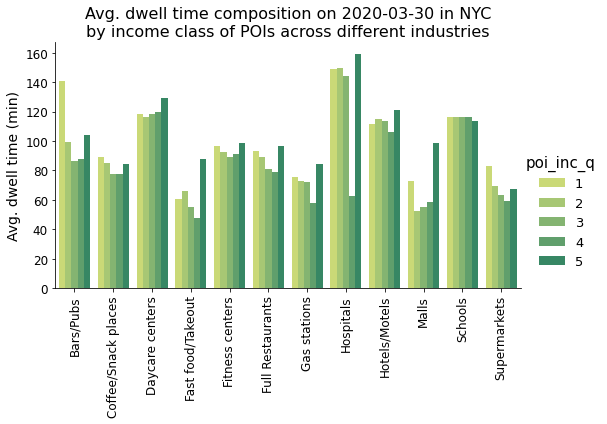

In [93]:
_ = dwell_by_naics_inc_on_date(nyc, '2020-03-30', 'avg_dwell5', True, out_hosp=False)

In [94]:
_.query('category == "Fast food/Takeout"').drop(columns=['category'])

poi_inc_q  avg_dwell5
3           1   60.333120
15          2   65.939968
27          3   55.313410
39          4   47.859175
51          5   87.755383

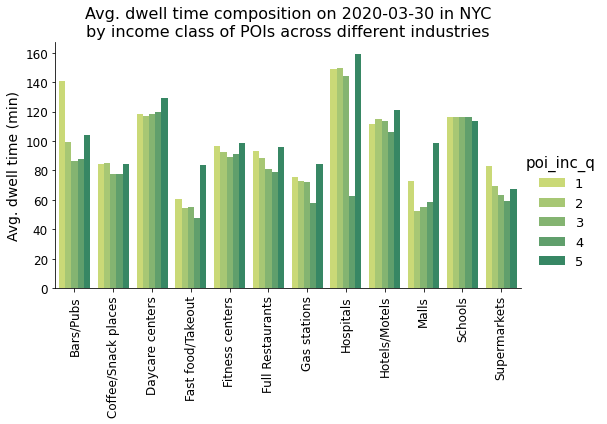

In [95]:
_ = dwell_by_naics_inc_on_date(nyc, '2020-03-30', 'avg_dwell5', True, out_hosp=True)

In [96]:
_.query('category == "Fast food/Takeout"').drop(columns=['category'])

poi_inc_q  avg_dwell5
3           1   60.333120
15          2   54.317442
27          3   55.313410
39          4   47.859175
51          5   83.566028

### Of specific industry

In [97]:
def dwell_by_inc_of_naics(city, week, industry, imp_zips=True, out_hosp=True):
    target_naics = g.IMP_NAICS.query(f'category == "{industry}"').index[0]
    # filter the data
    df = (get_odX(city, imp_zips, out_hosp)
          .query(f'naics == {target_naics}')
          .query('week == ' + week.replace('-', '')[2:])
          .drop(columns=['week', 'naics'])
          .merge(city.acs_zip['hh_inc_q'].rename('poi_inc_q'),
                 left_on='poi_zip', right_index=True)
          .groupby('poi_inc_q')
#           .groupby('home_inc_bin')
          .agg({**{'med_dwell': np.mean}, **{x: sum for x in [
              'poi_visitors', 'visits5', 'visits4', 'tot_dwell4',
              'tot_dwell5']}})
          .assign(avg_dwell4 = lambda x: x['tot_dwell4']/x['visits4'],
                  avg_dwell5 = lambda x: x['tot_dwell5']/x['visits5'])
          .drop(columns=['tot_dwell4', 'tot_dwell5'])
         )
    return df

CPU times: user 1.49 s, sys: 641 ms, total: 2.13 s
Wall time: 2.16 s


<AxesSubplot:xlabel='poi_inc_q'>

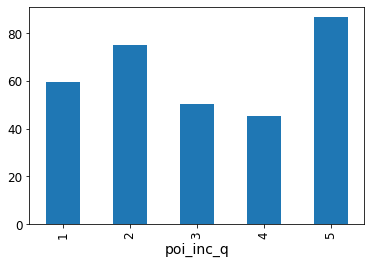

In [98]:
%time dwell_by_inc_of_naics(nyc, '2020-03-30', 'Fast food/Takeout', out_hosp=False)[['poi_visitors', 'avg_dwell5']].avg_dwell5.plot.bar()

In [99]:
%time dwell_by_inc_of_naics(nyc, '2020-03-30', 'Fast food/Takeout', out_hosp=True)[['poi_visitors', 'avg_dwell5']]

CPU times: user 1.46 s, sys: 658 ms, total: 2.12 s
Wall time: 2.14 s


poi_visitors  avg_dwell5
poi_inc_q                          
1              145659.0   59.622185
2              125452.0   51.306499
3               87241.0   50.178614
4              103650.0   45.432088
5               67182.0   74.062261

In [100]:
def od_dwell_by_naics_inc_on_date(city, week, dwell_var='avg_dwell5',
                                  inc_q_var='home_inc_q', imp_zips=True,
                                  out_hosp=True, plot=True):
    """
    Get the average dwell time on a specific date of different industries by
    income class of the POI zip but use the `city.od` table instead of `city.pat`.
    @param measure: <str> use one of these 3 measures to average dwell time:
        1. avg. of weekly median,
        2. avg. of 1st 4 bins,
        3. avg. of all bins with last bin = 240 min
    """
#     imp_pois = (city.pois.merge(g.IMP_NAICS, on='naics')
#                 [['poi_id', 'zip', 'category']])
    df = (get_odX(city, imp_zips, out_hosp)
          .query('week == ' + week.replace('-', '')[2:])
          .merge(g.IMP_NAICS['category'], on='naics')
          .merge(city.acs_zip['hh_inc_q'].rename('poi_inc_q'),
                 left_on='poi_zip', right_index=True)
          .merge(city.acs_zip['hh_inc_q'].rename('home_inc_q'),
                 left_on='home_zip', right_index=True)
          .groupby(['category', 'home_inc_q'])
#           .groupby(['category', 'poi_inc_q'])
          .agg({**{'med_dwell': np.mean}, **{x: sum for x in [
              'poi_visitors', 'visits4', 'visits5', 'tot_dwell4', 'tot_dwell5']}})
          .assign(avg_dwell4 = lambda x: x['tot_dwell4']/x['visits4'],
                  avg_dwell5 = lambda x: x['tot_dwell5']/x['visits5'])
          .drop(columns=['tot_dwell4', 'tot_dwell5'])
          [dwell_var].reset_index()
         )
    # plot the distribution
    if plot:
        p = sns.catplot(kind='bar', data=df, x='category', y=dwell_var,
                        hue=inc_q_var, palette=g.CMAPS['income_classes'],
                        aspect=1.8, height=4)
        ax = p.axes[0, 0]
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_xlabel('')
        ax.set_ylabel('Avg. dwell time (min)')
        if inc_q_var == 'poi_inc_q': label = 'POIs'
        elif inc_q_var == 'home_inc_q': label = 'home zips'
        else: label = ''
        ax.set_title(f'Avg. dwell time composition on {week} in {city.name}' +
                     f'\nby income class of {label} across different industries')
    return df

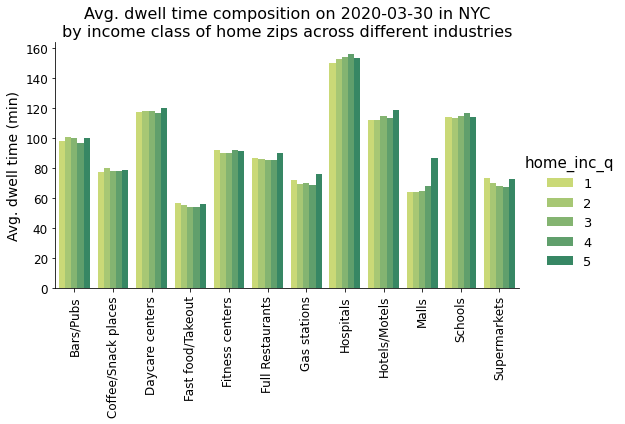

In [101]:
_1 = od_dwell_by_naics_inc_on_date(nyc, '2020-03-30', 'avg_dwell5')

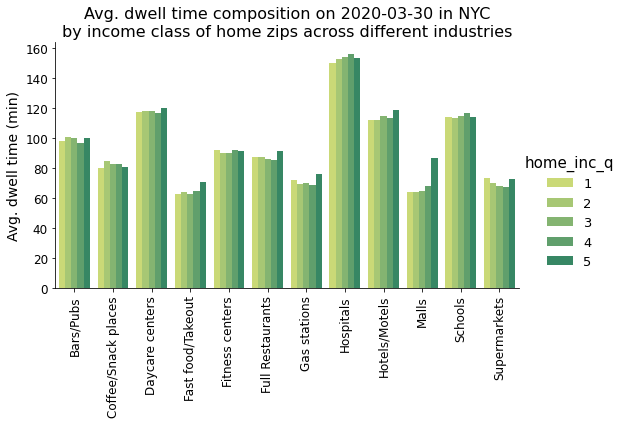

In [102]:
_2 = od_dwell_by_naics_inc_on_date(nyc, '2020-03-30', 'avg_dwell5', out_hosp=False)

In [103]:
pd.concat([_2.query('category == "Fast food/Takeout"')
           .set_index('home_inc_q')['avg_dwell5'].rename('before'),
           _1.query('category == "Fast food/Takeout"')
           .set_index('home_inc_q')['avg_dwell5'].rename('after')
           ], axis=1)

before      after
home_inc_q                      
1           62.677286  56.467545
2           64.268502  55.452168
3           62.924189  53.877509
4           64.483579  54.404006
5           70.584671  56.116437

## Exposure (<4 hr)

## Aggregate expsoure

### By POI zip income
Using patterns, not pat_od

In [104]:
def get_exp_by_poi_inc(city, exp_var='cei', nbins=5,
                        imp_zips=True, plot=True):
    """
    Get the weekly trend of average exposure over income class of home
    visitors.
    @param var: <str> exposure variable to be used
    (column name must be in `city.od`)
    """
    res = (get_pat(city, imp_zips)
           .merge(city.acs_zip['hh_inc_q'].rename('poi_inc_q'), on='zip')
           .groupby(['poi_inc_q', 'week'])
           [['tot_cei', 'exp_visits']].sum()
           .assign(cei = lambda x: x['tot_cei']/x['exp_visits'])
           .reset_index()
           .assign(week = lambda x: g.int2date(x['week']))
           .set_index('week')
          )
    if plot:
        fig, ax = plt.subplots()
        colors = sns.color_palette(g.CMAPS['income_classes'], g.INC_NBINS)
        for (bin_, df), col in zip(res.groupby(['poi_inc_q']), colors):
            (df[exp_var]).plot(ax=ax, color=col, label=f'Q{bin_}')
        plt.xlabel('')
        plt.ylabel('$CEI$ (min-persons/ft)')
        plt.legend()
        plt.title(f'Weekly avg. $CEI$ ({nbins} bins) by income\n' +
                  'quintile of home zip in ' + city.name);
    return res

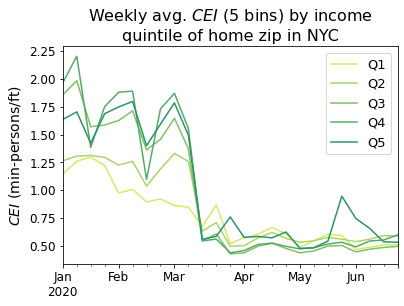

In [105]:
_ = get_exp_by_poi_inc(nyc)

### By home zip income 

In [106]:
def get_exp_by_home_inc(city, exp_var='cei', nbins=5,
                        imp_zips=True, plot=False):
    """
    Get the weekly trend of average exposure over income class of home
    visitors.
    @param var: <str> exposure variable to be used
    (column name must be in `city.od`)
    """
    res = (get_odX(city, imp_zips)
           .merge(city.acs_zip['hh_inc_q'].rename('home_inc_q'),
                  left_on='home_zip', right_index=True)
           .groupby(['week', 'poi_id', 'home_inc_q'])
           .agg({exp_var: 'first', 'home_visitors': sum})
           .assign(tot_exp = lambda x: x[exp_var]*x['home_visitors'])
           .reset_index()
          )
    # calculate the total home visitors of each POI
    tot_vis_by_poi = (res.groupby(['week', 'poi_id'])
                      ['home_visitors'].sum().rename('tot_home_visitors'))
    # now distribute the POI total exposure into its income class components
    # in proportion of the home visitors in its income classes
    res = (res
           .merge(tot_vis_by_poi, on=('week', 'poi_id'))
           .astype({'tot_exp': float, 'home_visitors': int,
                    'tot_home_visitors': float})
           .assign(tot_exp_inc = lambda x:
                   x['tot_exp']*x['home_visitors']/x['tot_home_visitors'])
           .drop(columns=['tot_exp'])
           .rename(columns={'tot_exp_inc': 'tot_'+exp_var})
           .groupby(['week', 'home_inc_q'])
           .sum()
           .assign(avg_exp = lambda x: x['tot_'+exp_var]/x['home_visitors'])
           .rename(columns={'avg_exp': 'avg_'+exp_var})
           .drop(columns=['tot_'+exp_var, 'tot_home_visitors'])
           .reset_index()
           .assign(week = lambda x: g.int2date(x['week']))
           .set_index('week')
          )
    if plot:
        fig, ax = plt.subplots()
        colors = sns.color_palette(g.CMAPS['income_classes'], g.INC_NBINS)
        for (bin_, df), col in zip(res.groupby(['home_inc_q']), colors):
            (df['avg_'+exp_var]).plot(ax=ax, color=col, label=f'Q{bin_}')
        plt.xlabel('')
        plt.ylabel('$CEI$ (min-persons/ft)')
        plt.legend()
        plt.title(f'Weekly avg. $CEI$ ({nbins} bins) by income\n' +
                  'quintile of home zip in ' + city.name);
    return res

CPU times: user 19.3 s, sys: 4.45 s, total: 23.8 s
Wall time: 24 s


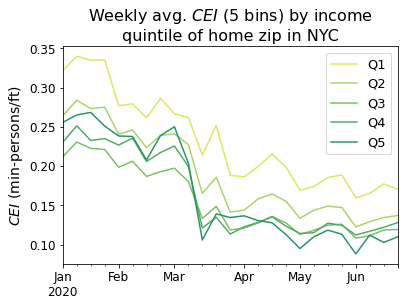

In [107]:
%time _ = get_exp_by_home_inc(nyc, plot=True)

### By home zip

In [108]:
def get_exp_by_home_zip(city, imp_zips=True, nbins=4):
    """
    Get the weekly trend of average exposure of each zip code of home
    visitors.
    """
    odX = (get_odX(city, imp_zips)
           .assign(tot_exp = lambda x: x['cei']*x['home_visitors'])
           [['poi_id', 'week', 'home_zip', 'home_visitors', 'tot_exp']]
          )
    # calculate the total home visitors of each POI
    tot_vis_by_poi = (odX.groupby(['week', 'poi_id'])
                      ['home_visitors'].sum().rename('tot_home_visitors'))
    # now distribute the POI total exposure into its income class components
    # in proportion of the home visitors in its income classes
    res = (odX
           .merge(tot_vis_by_poi, on=('week', 'poi_id'))
           .astype({'tot_exp': float, 'home_visitors': int,
                    'tot_home_visitors': float})
           .assign(zip_exp = lambda x:
                   x['tot_exp']*x['home_visitors']/x['tot_home_visitors'])
           .groupby(['week', 'home_zip'])
           [['tot_exp', 'home_visitors']]
           .sum()
           .assign(avg_exp = lambda x: x['tot_exp']/x['home_visitors'])
           .reset_index()
           .assign(week = lambda x: g.int2date(x['week']))
          )
    return res

In [109]:
%%time
nyc.cei_zip_wk = get_exp_by_home_zip(nyc, True)
peek(nyc.cei_zip_wk)

Shape: (4275, 5), Memory: 0.163 MB
CPU times: user 5.79 s, sys: 2.39 s, total: 8.18 s
Wall time: 8.24 s


week  home_zip       tot_exp  home_visitors   avg_exp
0 2020-01-06     10001  43208.038902          46546  0.928287
1 2020-01-06     10002  52313.959815          60897  0.859056
2 2020-01-06     10003  30811.283980          36247  0.850037

In [152]:
%time chi.cei_zip_wk = get_exp_by_home_zip(chi, True)

CPU times: user 4.87 s, sys: 3.43 s, total: 8.31 s
Wall time: 9.06 s


## Cases vs exposure (snapshot)

In [216]:
def plot_cases_vs_mob_by_zip(city, week, xvar='tot_cei', yvar='new_cases',
                             plot=True, plot_kde=True, regress=True, dpi=70,
                             xmin=0, xmax=None, ymin=0, ymax=None):
    """
    Scatterplot of cases vs mobility measure on a given weekdate where each
    point represents a zip code which is colored by its income level.
    """
    # agg the new cases by zip & week
    cases = city.cases.groupby(['zip', 'week'])['new_cases'].sum().reset_index()
    # fetch the CEI by zip & week
    cei_zip = (city.cei_zip_wk
               .rename(columns={'avg_exp': 'avg_cei', 'home_zip': 'zip'}))
    # calc. total CEI
    res = (cei_zip.assign(tot_cei = lambda x: x['avg_cei'] * x['home_visitors']))
    # join with the cases data
    res = res.merge(cases, on=('week', 'zip'))
    # filter the data on the given date
    res = res[res['week'] == g.str2date(week)].drop(columns='week')
    # get the income bin of the home zip
    res = res.merge((city.acs_zip[['tot_pop', 'hh_inc_q']]
                     .rename(columns={'hh_inc_q': 'home_inc_q'})), on='zip')
    # get the values per unit population
    res['tot_cei_per_pop'] = res['tot_cei']/(res['tot_pop']/1000)
    res['cases_per_pop'] = res['new_cases']/(res['tot_pop']/1000)
    
    if plot:
        fig = plt.figure(figsize=(8, 3.5), dpi=dpi)
        gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[2.5, 1])
        ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
        twin = ax1.twinx()
        colors = g.COLORS['income_classes5']
        markers = ['o', '^', '*', 'P', 'd']        
        
        # 1st axes: cases vs total exposure scatterplot
        for i, (bin_, df) in enumerate(res.groupby('home_inc_q')):
            X, Y = df[xvar], df[yvar]
            if xvar == 'home_visitors':
                X = X/1000
            if regress:
                model = LinearRegression(fit_intercept=False)
                model.fit(X.values.reshape((-1,1)), Y.values)
                m = model.coef_[0]
                ax1.plot(X.values, m*X.values, color=colors[i], lw=0.5)
            if plot_kde:
                X.plot.kde(ax=twin, color=colors[i], lw=1, ls='--')
            pts = ax1.scatter(X, Y, color=colors[i], label=f'Q{bin_}', s=30,
                              marker=markers[i])
        ax1.set_xlim(xmin, xmax)
        ax1.set_ylim(ymin, ymax)
        xlabels = {'tot_cei': 'Total CEI (min/ft)',
                   'tot_cei_per_pop': 'Total CEI (min/ft) per 1000 residents',
                   'home_visitors': 'Total visitors (k)',
                   'avg_cei': 'Avg. CEI (min/ft)'}
        ylabels ={'new_cases': 'New weekly cases',
                  'cases_per_pop': 'Weekly case rate\n(per 1000 residents)'}
        ytitle = 'Case rate' if yvar == 'cases_per_pop' else 'Cases'
        titles = {'tot_cei': f'{ytitle} vs total exposure',
                  'tot_cei_per_pop': f'{ytitle} vs total exposure per unit population',
                  'home_visitors': f'{ytitle} vs total no. of visitors',
                  'avg_cei': f'{ytitle} vs avg. CEI'}
        ax1.set_xlabel(xlabels[xvar])
        ax1.set_ylabel(ylabels[yvar])
        wk = g.str2date(week)
        ax1.set_title('{}\n in {} during {} - {}'.format(
            titles[xvar], city.name, wk.strftime("%d %b"),
            (wk + pd.DateOffset(days=6)).strftime("%d %b")))
        ax1.legend(fontsize=10)
        
        # 2nd axes: total visitors by income class
        visitors = res.groupby('home_inc_q')['home_visitors'].sum()/1e3
        visitors.plot.barh(ax=ax2, x='home_inc_q', y='home_visitors', color=colors)
        ax2.set_xlabel('Total home visitors (k)')
        ax2.set_ylabel('Income class')
        ax2.set_title('Visitor income\ndistribution')
        for i, v in enumerate(visitors):
            ax2.text(20, i-0.1, f'{v/visitors.sum()*100:.2f}%')
        plt.tight_layout()
        
    return res

### Total CEI

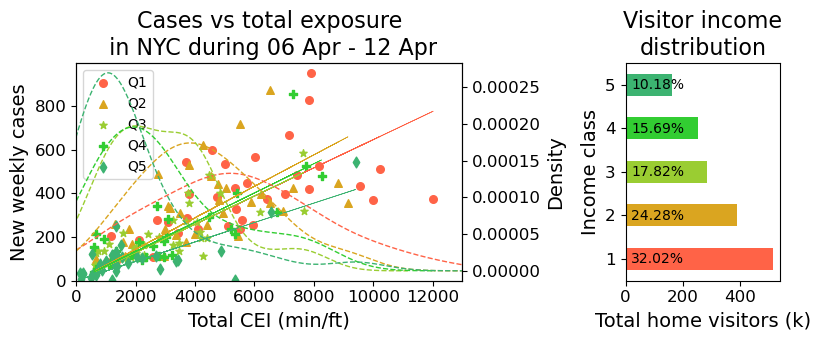

In [217]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-04-06', 'tot_cei', xmax=13000, dpi=100)

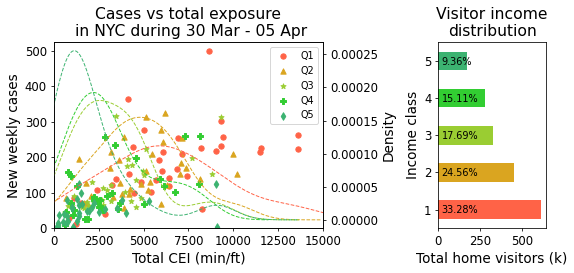

In [113]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-03-30', 'tot_cei', xmax=15000)

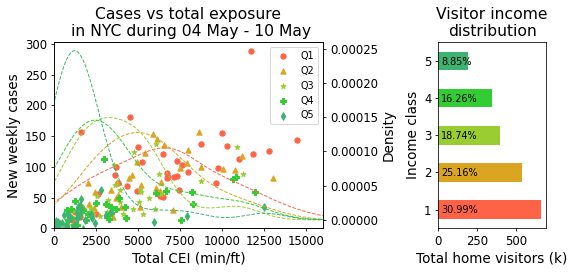

In [114]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-05-04', 'tot_cei', xmax=16000)

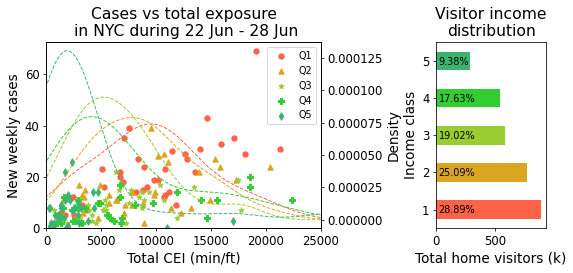

In [115]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-06-22', 'tot_cei', xmax=25000)

### Total CEI per unit population

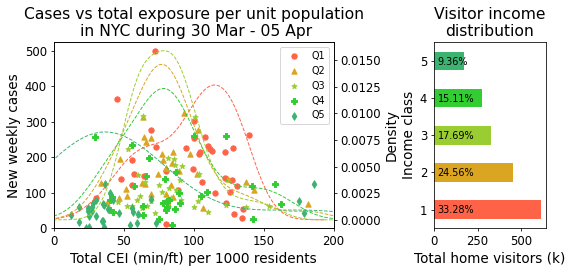

In [116]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-03-30', 'tot_cei_per_pop', xmax=200)

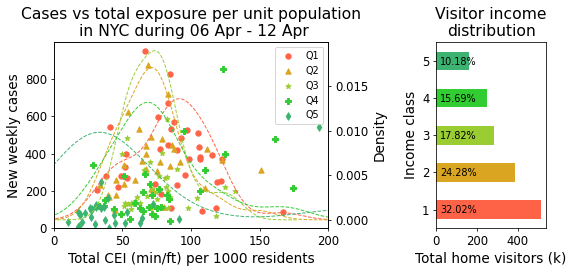

In [117]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-04-06', 'tot_cei_per_pop', xmax=200)

### Total CEI & cases per unit population

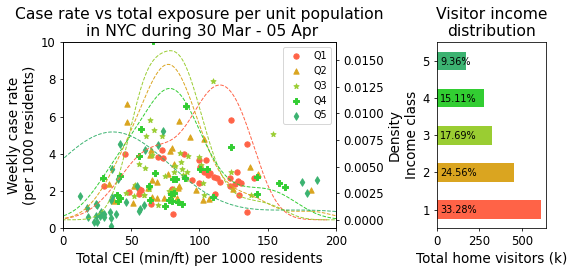

In [118]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-03-30', 'tot_cei_per_pop', 'cases_per_pop', xmax=200, ymax=10)

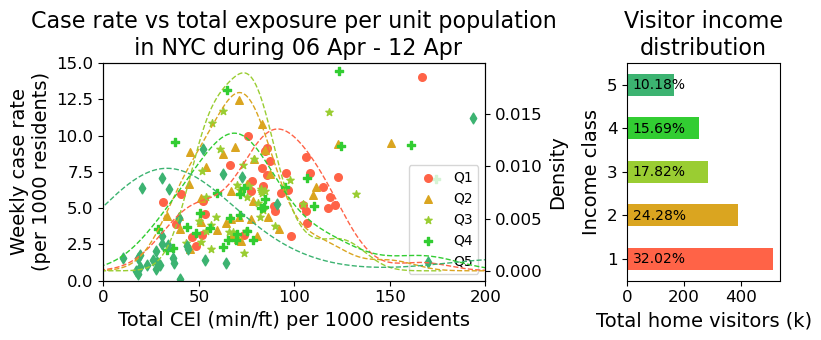

In [181]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-04-06', 'tot_cei_per_pop', 'cases_per_pop',
                             regress=False, xmax=200, ymax=15, dpi=100)

### Avg CEI

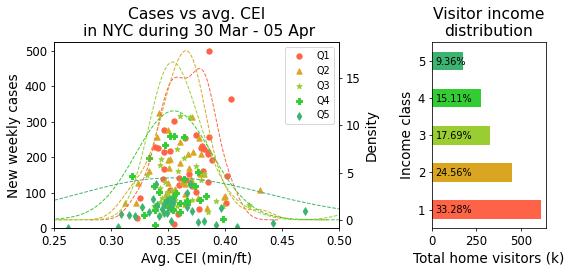

In [120]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-03-30', 'avg_cei', xmin=0.25, xmax=0.5)

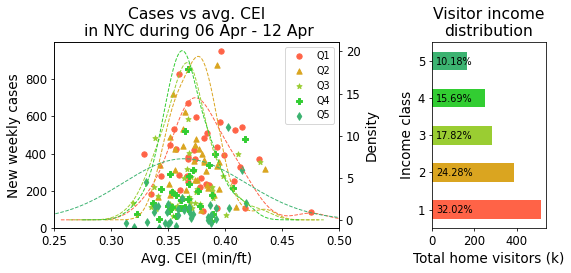

In [121]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-04-06', 'avg_cei', xmin=0.25, xmax=0.5)

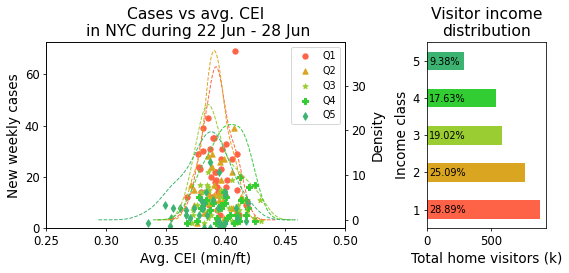

In [122]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-06-22', 'avg_cei', xmin=0.25, xmax=0.5)

### Total visitors

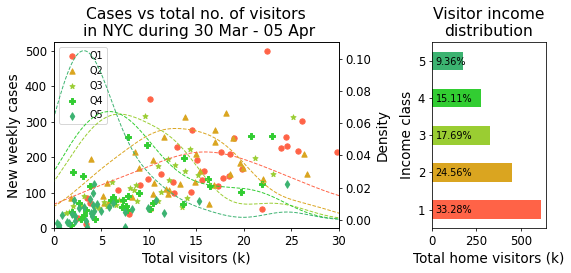

In [123]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-03-30', 'home_visitors', xmax=30)

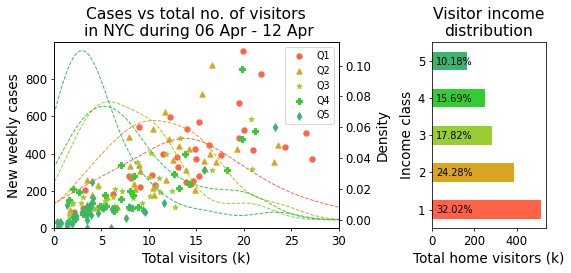

In [124]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-04-06', 'home_visitors', xmax=30)

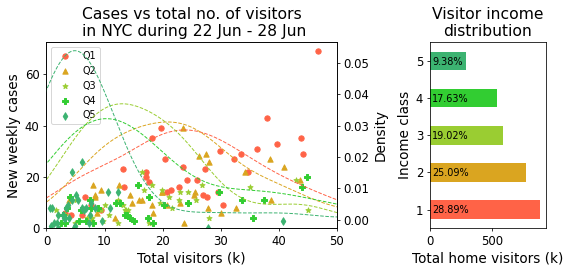

In [125]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-06-22', 'home_visitors', xmax=50)

---
# Modeling

## Cases vs exposure
Level: Zip-daily

### Get the data

In [126]:
def get_modelX(city, xvar='tot_cei', lag=7, start_date='2020-03-01', dropna=True):
    """
    Prepare the dataset for training the SEM model as shown in the PNAS paper
    https://www.pnas.org/content/117/44/27087
    """
    # get the zip-daily level exposure data
    res = (
        city.exp_daily
        .reset_index(['poi_id', 'date'])
        .pipe(lambda x: x[x['date'] >= g.strdate2int(start_date)])
        .merge(city.pois['zip'], on='poi_id')
        .merge(city.imp_zips)
        .assign(tot_cei = lambda x: x['cei']*x['exp_visits'])
        .groupby(['zip', 'date'])
        [['exp_visits', 'tot_cei']].sum()
        .assign(avg_cei = lambda x: x['tot_cei']/x['exp_visits'])
        .reset_index()
        .assign(date = lambda x: g.int2date(x['date']))
    )
    # add the social distancing info
    sd = (g.map_cbg_zip(city.sd.reset_index())
          .assign(tot_time_home = lambda x: x['time_home']*x['tot_dev'])
          .drop(columns=['cbg', 'time_home'])
          .groupby(['zip', 'date']).sum()
          .reset_index()
          .merge(city.imp_zips, on='zip')
          .assign(prop_home = lambda x: x['dev_home']/(x['tot_dev']+1),
                  time_home = lambda x: x['tot_time_home']/(x['tot_dev']+1))
          .drop(columns=['tot_time_home', 'dev_home'])
          .astype({'tot_dev': np.int32})
         )
    res = res.merge(sd, on=('zip', 'date'))
    
    # add census data
    res = (res.merge(city.acs_zip[['avg_hh_income'] + g.VUL_VARS], on='zip')
           .assign(income = lambda x: x['avg_hh_income']/1e3)
           .drop(columns=['avg_hh_income'])
          )
    # add cases data
    res = (res.merge(city.cases
                     .rename(columns={'new_cases': 'cases', 'new_tests': 'tests'})
                     [['zip', 'date', 'cases', 'tests']],
                     on=('zip', 'date'), how='left')
           .pipe(lambda x: x[x['date'] <= g.int2date(200628)])
           .sort_values('date')
           .assign(cases = lambda x: x['cases'].fillna(0),
                   tests = lambda x: x['tests'].fillna(0))
    )
    # get the lag adjusted measures
    res = pd.concat([
        res, res.groupby('zip')['cases'].shift().rename('cases_prev'),
        res.groupby('zip')['tests'].shift().rename('tests_prev'),
        res.groupby('zip')[xvar].shift(lag).rename(xvar+'_lag'),
        res.groupby('zip')[xvar].shift(lag+1).rename(xvar+'_lag_prev')
    ], axis=1)
    res = res.set_index(['zip', 'date']).sort_index()
    
    # make sure all values are non-negative
    res = res[res >= 0].reset_index()
    # add the log columns
    xyvars = ['cases', 'cases_prev', 'tests', 'tests_prev', 'income',
              xvar+'_lag', xvar+'_lag_prev']
    for var in xyvars:
        res['log_'+var] = np.log(1 + res[var])
    if dropna:
        res = res.dropna()
    
    return res

# get_modelX(nyc)

In [127]:
%%time
nyc.modelX = get_modelX(nyc, dropna=False)
peek(nyc.modelX)

Shape: (20401, 28), Memory: 3.697 MB
CPU times: user 1.67 s, sys: 645 ms, total: 2.32 s
Wall time: 2.98 s


zip       date  exp_visits       tot_cei   avg_cei  tot_dev  prop_home  \
0  10001 2020-03-01        7659   6333.294434  0.826909     1957   0.276813   
1  10001 2020-03-02       13187  15049.003906  1.141200     2047   0.246582   
2  10001 2020-03-03       13991  16930.734375  1.210116     2168   0.242508   

   time_home  frac_poor  frac_low_edu  ...  tests_prev  tot_cei_lag  \
0   6.498374   0.532339      0.278937  ...         NaN          NaN   
1   6.153621   0.532339      0.278937  ...         0.0          NaN   
2   5.387782   0.532339      0.278937  ...         0.0          NaN   

   tot_cei_lag_prev  log_cases  log_cases_prev  log_tests  log_tests_prev  \
0               NaN        0.0             NaN        0.0             NaN   
1               NaN        0.0             0.0        0.0             0.0   
2               NaN        0.0             0.0        0.0             0.0   

   log_income  log_tot_cei_lag  log_tot_cei_lag_prev  
0    5.153979              NaN                   NaN  
1    5.153979              NaN                   NaN  
2    5.153979              NaN                   NaN  

[3 rows x 28 columns]

In [128]:
%%time
il.modelX = get_modelX(il, dropna=False)
peek(il.modelX)

Shape: (74070, 28), Memory: 13.421 MB
CPU times: user 2.59 s, sys: 1.16 s, total: 3.75 s
Wall time: 4.38 s


zip       date  exp_visits      tot_cei   avg_cei  tot_dev  prop_home  \
0  60002 2020-03-01        1015   995.747864  0.981032     3483   0.281573   
1  60002 2020-03-02         767   441.462799  0.575571     3578   0.261526   
2  60002 2020-03-03        1443  7050.203125  4.885796     3635   0.187844   

   time_home  frac_poor  frac_low_edu  ...  tests_prev  tot_cei_lag  \
0  13.705205   0.521155      0.674858  ...         NaN          NaN   
1  11.315237   0.521155      0.674858  ...         0.0          NaN   
2   9.363233   0.521155      0.674858  ...         0.0          NaN   

   tot_cei_lag_prev  log_cases  log_cases_prev  log_tests  log_tests_prev  \
0               NaN        0.0             NaN        0.0             NaN   
1               NaN        0.0             0.0        0.0             0.0   
2               NaN        0.0             0.0        0.0             0.0   

   log_income  log_tot_cei_lag  log_tot_cei_lag_prev  
0    4.546872              NaN                   NaN  
1    4.546872              NaN                   NaN  
2    4.546872              NaN                   NaN  

[3 rows x 28 columns]

In [129]:
chi.modelX = il.modelX.merge(chi.zips, on='zip')

### Visualize

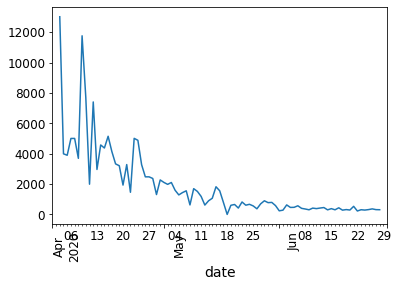

In [130]:
(nyc.cases.groupby('date')['new_cases'].sum()
.pipe(lambda x: x[(x.index > g.int2date(200402)) & (x.index <= g.int2date(200628))])
# .rolling(7).mean()
 .plot())
plt.xlim(g.int2date(200401), g.int2date(200630))
plt.xticks(rotation=90);

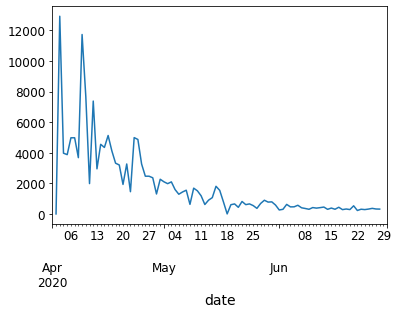

In [131]:
(nyc.modelX.groupby('date')['cases'].sum()
 .pipe(lambda x: x[x.index >= g.int2date(200402)])
#  .rolling(7).mean()
 .plot())
plt.xlim(g.int2date(200401), g.int2date(200630));

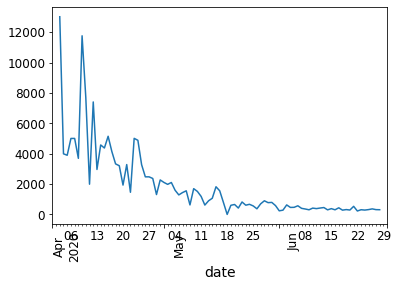

In [132]:
(nyc.cases.groupby('date')['new_cases'].sum()
.pipe(lambda x: x[(x.index > g.int2date(200402)) & (x.index <= g.int2date(200628))])
# .rolling(7).mean()
 .plot())
plt.xlim(g.int2date(200401), g.int2date(200630))
plt.xticks(rotation=90);

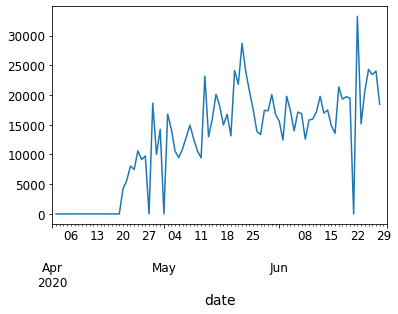

In [133]:
(il.modelX.groupby('date')['tests'].sum()
 .pipe(lambda x: x[x.index >= g.int2date(200402)])
#  .rolling(7).mean()
 .plot())
plt.xlim(g.int2date(200401), g.int2date(200630));

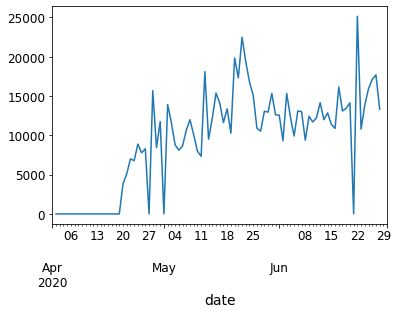

In [134]:
(chi.modelX.groupby('date')['tests'].sum()
 .pipe(lambda x: x[x.index >= g.int2date(200402)])
#  .rolling(7).mean()
 .plot())
plt.xlim(g.int2date(200401), g.int2date(200630));

### Export it

In [135]:
nyc.modelX.dropna().to_csv(nyc.dir + '/zip_modelX.csv', index=False)

In [136]:
il.modelX.dropna().to_csv(il.dir + '/zip_modelX.csv', index=False)

In [137]:
chi.modelX.dropna().to_csv(chi.dir + '/zip_modelX.csv', index=False)

## Visualize

AttributeError: 'City' object has no attribute 'cei_zip_wk'

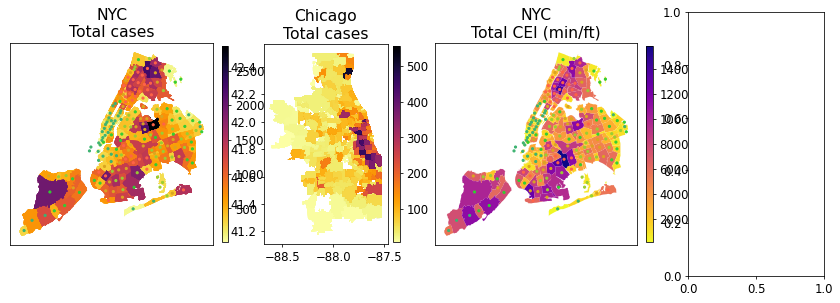

In [138]:
%%time
def fig_study_area_horz(date='2020-04-20', dpi=70):
    date = g.str2date(date)
    last_week = [date - pd.DateOffset(days=x) for x in range(7)]
    fig = plt.figure(figsize=(15, 5), dpi=dpi)
    gs = mpl.gridspec.GridSpec(1, 4, width_ratios=[1.6, 1, 1.6, 1])
    
    def plot_colorbar(ax, data, cmap, frac=0.03):
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(
            vmin=data.min(), vmax=data.max())); sm._A = []
        cbar = fig.colorbar(sm, ax=ax, fraction=frac, pad=0.04, aspect=30)
    
    for i, c in enumerate([nyc, chi]):
        ax0 = plt.subplot(gs[0, i])
        ax1 = plt.subplot(gs[0, i+2])

        # plot cases of the last week
        cases = gp.GeoDataFrame(
            c.cases.pipe(lambda x: x[x['date'].isin(last_week)])
            [['zip', 'cum_cases']].merge(c.shp_zip))
        min_cases, max_cases = cases['cum_cases'].min(), cases['cum_cases'].max()
        cases.plot(column='cum_cases', cmap='inferno_r', ax=ax0)
        ax0.set_title('{}\nTotal cases'.format(c.name))
        plot_colorbar(ax0, cases['cum_cases'], 'inferno_r', frac=0.03 if c==nyc else 0.048)

        # plot exposure
        exp = gp.GeoDataFrame(
#             (c.modelX.reset_index()
#             .pipe(lambda x: x[x['date'] <= date])
#             .groupby('zip')['tot_cei'].sum()/1e5.reset_index()
            c.cei_zip_wk.pipe(lambda x: x[x.week == date])
            .rename(columns={'home_zip': 'zip', 'tot_exp': 'tot_cei'})
            .merge(c.shp_zip))
        min_exp, max_exp = exp['tot_cei'].min(), exp['tot_cei'].max()
        exp.plot(column='tot_cei', cmap='plasma_r', ax=ax1)
        ax1.set_title('{}\nTotal CEI (min/ft)'.format(c.name))
        plot_colorbar(ax1, exp['tot_cei'], 'plasma_r', frac=0.03 if c==nyc else 0.048)
        
        # plot the centroids
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            inc_colors = {i+1: g.COLORS['income_classes5'][i] for i in range(5)}
            centroids = (c.shp_zip.merge(c.acs_zip['hh_inc_q'], on='zip')
                         .assign(centroid = lambda x: x['geometry']
                                 .to_crs(epsg=4269).centroid,
                                 color = lambda x: x['hh_inc_q'].map(inc_colors))
                         .drop(columns=['geometry'])
                         .rename(columns={'centroid': 'geometry'}))
        for ax_ in [ax0, ax1]:
            centroids.plot(ax=ax_, color=centroids['color'], markersize=5)
            ax_.set_xticks([])
            ax_.set_yticks([])
    plt.tight_layout()
    
fig_study_area_horz()

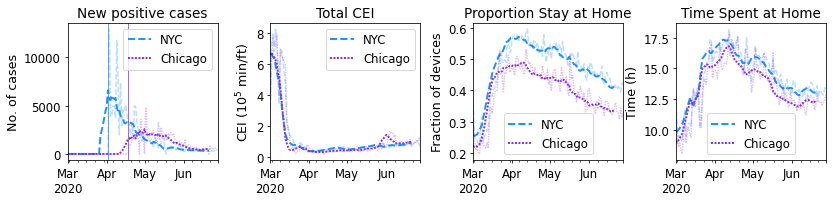

In [139]:
def fig_overall_trends(win=7, dpi=70):
    fig, ax = plt.subplots(1, 4, figsize=(12, 3), dpi=dpi)
    ax = ax.flatten()
    for c, ls, start in zip([nyc, chi], ['--', (0, (1, 0.8))], [200402, 200418]):
        df = (c.modelX[['date', 'cases', 'tot_cei', 'tot_dev', 'prop_home', 'time_home']]
              .assign(tot_time_home = lambda x: x['time_home']*x['tot_dev'],
                      dev_home = lambda x: x['prop_home']*x['tot_dev'])
              .groupby('date').sum()
#               .agg({'tot_cei': np.mean, 'tot_time_home': sum, 'dev_home': sum,
#                     'tot_dev': sum, 'cases': sum})
              .assign(time_home = lambda x: x['tot_time_home']/x['tot_dev'],
                      prop_home = lambda x: x['dev_home']/x['tot_dev'])
              .drop(columns=['tot_time_home', 'dev_home', 'tot_dev']))
        
        def plot_trend(data, ax, title, ylab, lgnd=c.name):
            data.plot(ax=ax, alpha=0.3, color=c.color, ls=ls, label='_')
            data.rolling(win).mean().shift(-win).plot(ax=ax, color=c.color, ls=ls, lw=2, label=lgnd)
            ax.set_title(title, fontsize=14)
            ax.set_xlabel('')
            ax.set_ylabel(ylab, fontsize=13)
            ax.legend(fontsize=12)
        
        plot_trend(df['cases'], ax[0], 'New positive cases', 'No. of cases')
        plot_trend(df['tot_cei']/1e5, ax[1], 'Total CEI', 'CEI ($10^5$ min/ft)')
        plot_trend(df['prop_home'], ax[2], 'Proportion Stay at Home', 'Fraction of devices')
        plot_trend(df['time_home'], ax[3], 'Time Spent at Home', 'Time (h)')
        
        # first dates of the cases data
        ax[0].axvline(g.int2date(start), color=c.color, lw=0.75, ls='-')
#         ax[0].text(g.int2date(start + 2), 0, 'Cases available', rotation=90,
#                    ha='left', va='bottom', fontsize=8, color='k')
        
    plt.tight_layout()
    
fig_overall_trends()

CPU times: user 6.05 s, sys: 1.06 s, total: 7.11 s
Wall time: 6.23 s


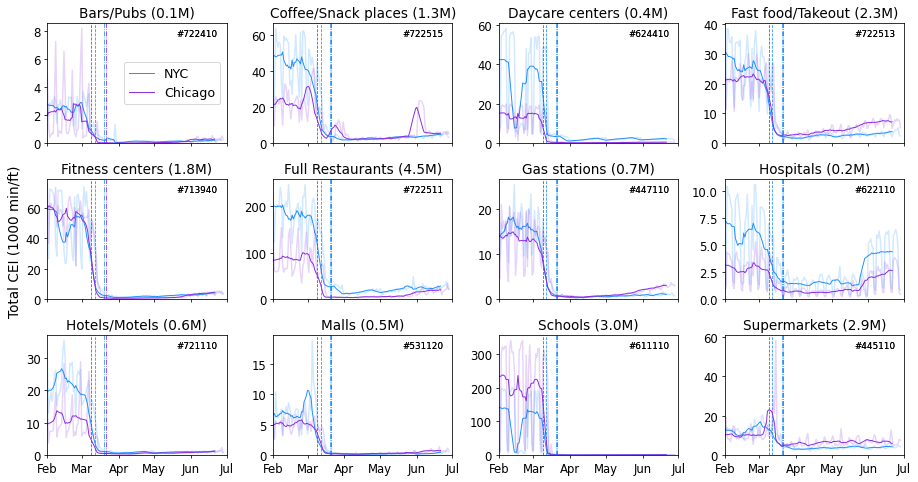

In [140]:
%%time
def fig_exp_by_nacis(plot=True, start='2020-02-01', dpi=70):
    if plot:
        nrow, ncol = 3, 4
        fig, axs = plt.subplots(nrow, ncol, figsize=(13, 7), dpi=dpi,
                                sharex=True, sharey=False)
    daily_exp = pd.DataFrame()
    for c in [nyc, chi]:
        res = (c.exp_daily.reset_index()
               .assign(tot_cei = lambda x: x['cei']*x['exp_visits'])
               .merge(c.pois['naics'], on='poi_id')
               .merge(g.IMP_NAICS['category'], on='naics', how='left')
               .replace(np.nan, 'Others')
               .groupby(['category', 'date'])
               [['exp_visits', 'tot_cei']].sum()
               .reset_index()
               .assign(date = lambda x: g.int2date(x['date']))
               .set_index('date'))
        daily_exp = daily_exp.append(res.reset_index().assign(city=c.name))
        # plot
        if plot:
            for n, (cat, df) in enumerate(res.query('category != "Others"')
                                          .groupby('category')):
                df = df[df.index >= g.str2date(start)]
                # resolve the axes index
                i, j = n // ncol, n % ncol
                ax = axs[i][j]
                # total CEI
                ax.plot(df['tot_cei']/1e3, color=c.color, alpha=0.2)
                ax.plot(g.roll_avg(df['tot_cei']/1e3), color=c.color, lw=1,
                         label=c.name)
                # decoration
                if i == nrow-1:
                    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
                if n == 0:
                    ax.legend(loc='center right')
                # axes title & caption
                naics_code = g.IMP_NAICS.query(f'category == "{cat}"').index[0]
                ax.set_title(f'{cat} ({df.exp_visits.sum()/1e6:.1f}M)', fontsize=14)
                ax.text(0.95, 0.95, f'#{naics_code}', transform=ax.transAxes,
                        fontsize=9, va='top', ha='right')
                ax.set_xlim(g.str2date(start), g.int2date(200701))

                # plot events
                for evt, ls in zip(['Emergency declared', 'SAH ordered'], ['--', '-.']):
                    date = g.str2date(c.events[evt])
                    ax.axvline(date, color=c.color, ls=ls, lw=0.8)
    for ax_ in axs.flatten():
        ax_.set_ylim(0, ax_.get_ylim()[1])
    if plot:
        fig.text(-0.005, 0.5, 'Total CEI (1000 min/ft)',
                 va='center', rotation='vertical', fontsize=14)
        plt.tight_layout()
    return daily_exp
    
# fig_exp_by_nacis()
daily_exp = fig_exp_by_nacis(dpi=70)

In [141]:
peek(daily_exp)

Shape: (4680, 5), Memory: 0.709 MB


date   category  exp_visits      tot_cei city
0 2020-01-01  Bars/Pubs      1224.0  1290.173706  NYC
1 2020-01-02  Bars/Pubs      2134.0  5750.138672  NYC
2 2020-01-03  Bars/Pubs      2403.0  4083.527344  NYC

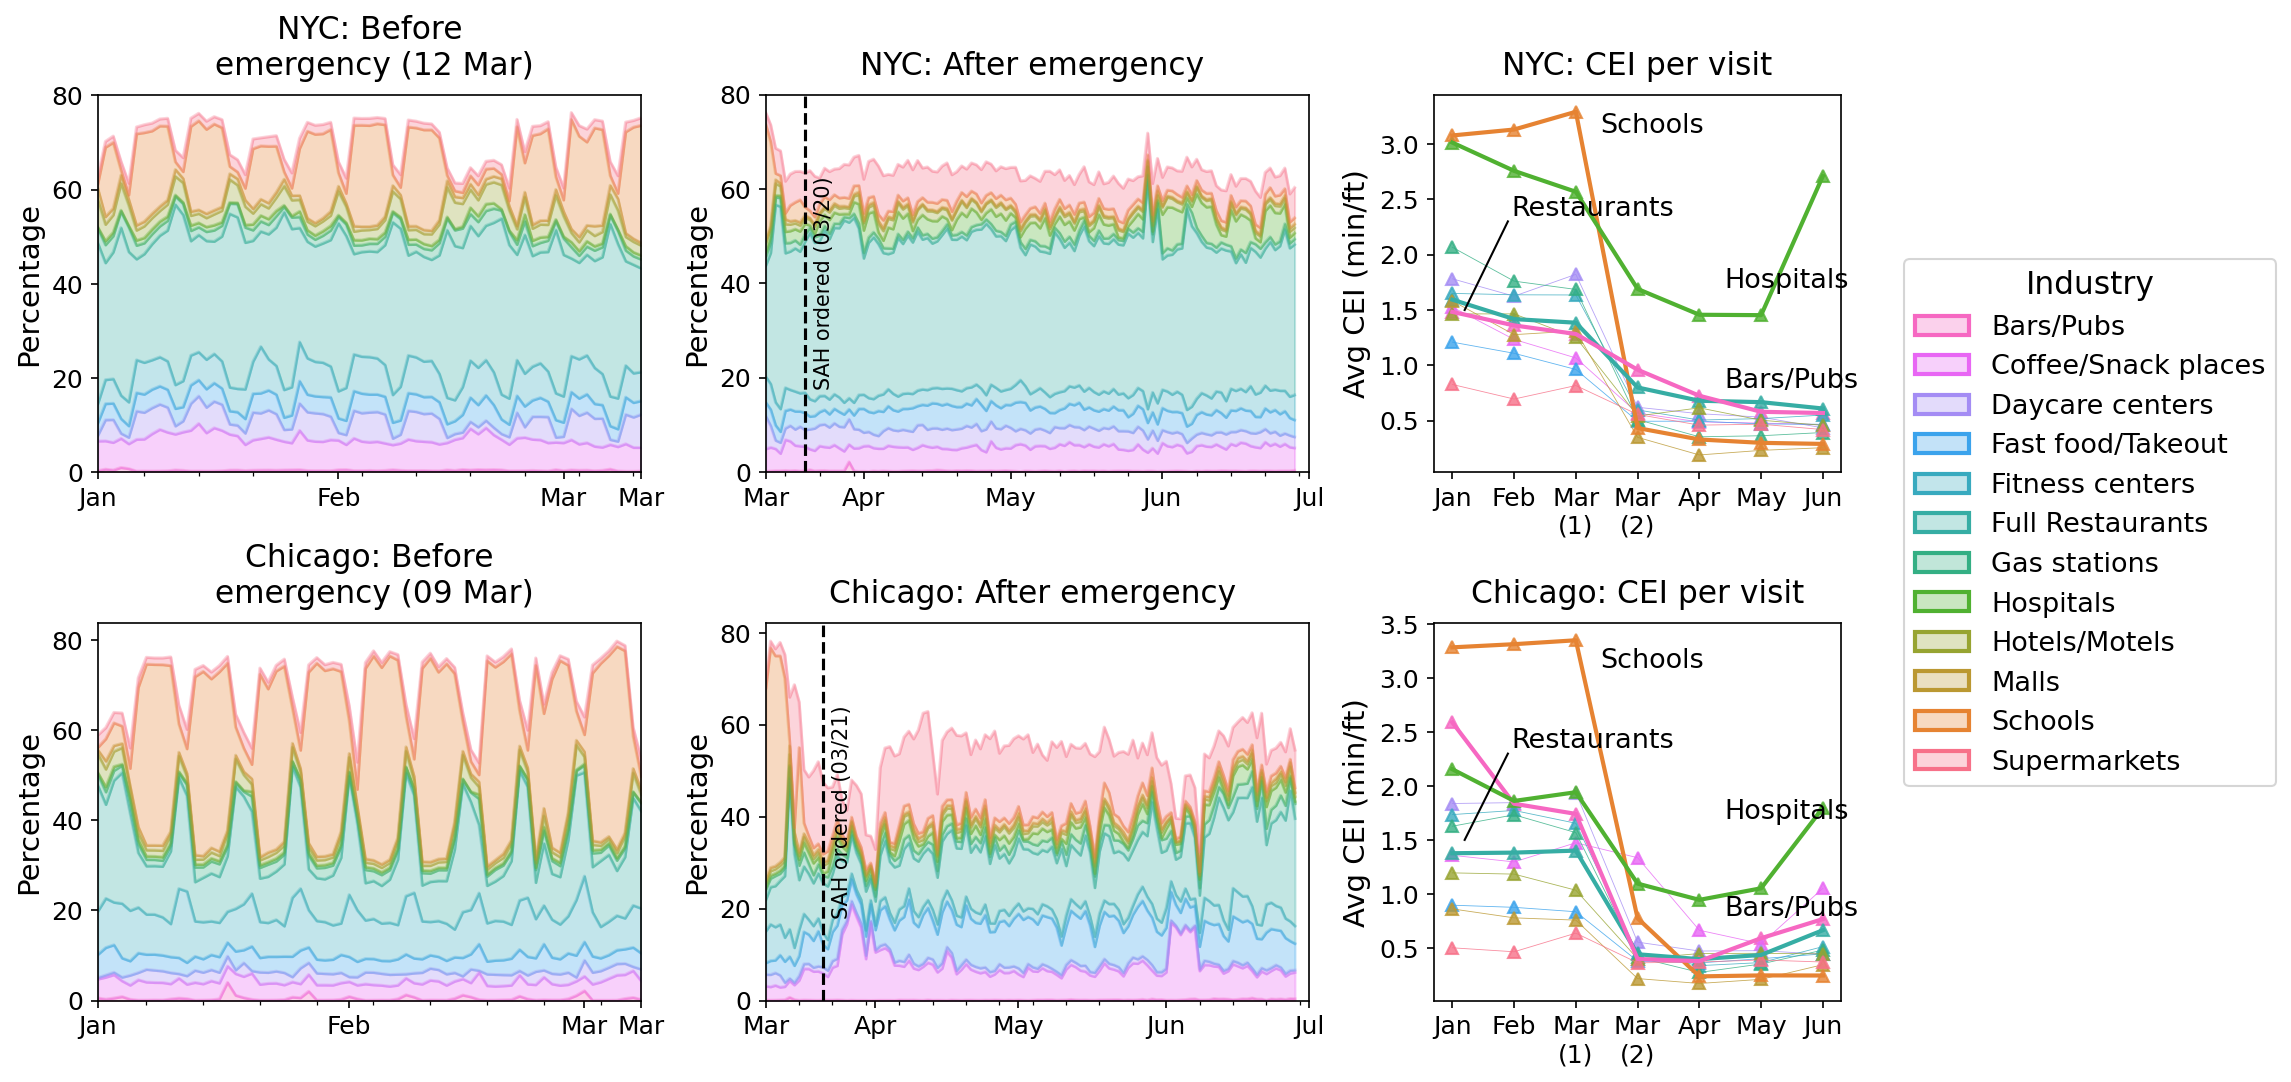

In [264]:
def fig_exp_coverage_by_naics(daily_exp, win=1, dpi=70):
    fig = plt.figure(figsize=(15, 8), dpi=dpi)
    gs = mpl.gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.75])
    for i, c in enumerate([nyc, chi]):
        # resolve dates
        dt_emerg = g.str2date(c.events['Emergency declared'])
        dt_sah = g.str2date(c.events['SAH ordered'])
        
        # prepare the contribution data
        df = (daily_exp.rename(columns={'tot_cei': 'cei', 'exp_visits': 'vis'})
               .pivot(index=['city', 'date'], columns='category',
                               values=['vis', 'cei']).reset_index('date')
               .loc[c.name].set_index('date').rolling(win).mean())
        # exposure distribution
        tot_cei = df['cei'].sum(axis=1)
        cei = df['cei'].drop(columns=['Others'])
        pdf = cei/tot_cei.values[:, None]*100
        
        # avg CEI series by NAICS grouped by custom periods
        avg_cei = df['cei'] / df['vis']
        periods = (pd.DataFrame.from_dict(
            {'Jan': 200131, 'Feb': 200229, 'Mar\n(1)': 200315,
             'Mar\n(2)': 200331, 'Apr': 200430, 'May': 200531, 'Jun': 200630},
            orient='index', columns=['date_int']).rename_axis('period')
                   .assign(date = lambda x: g.int2date(x['date_int'])))
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            df['period'] = (pd.cut(df.index, [g.str2date('2019-12-31')] +
                                        periods['date'].tolist()))
            df['period'] = periods.index[df['period'].cat.codes]
            grp_df = df.groupby('period').sum()
            avg_cei = (grp_df['cei'] / grp_df['vis']).reindex(periods.index)
        
        # plot
        colors = sns.color_palette('husl', 12)[::-1]
        ax1 = plt.subplot(gs[i, 0])
        ax2 = plt.subplot(gs[i, 1])
        ax3 = plt.subplot(gs[i, 2])
        
        # total CEI before & after emergency
        pdf[pdf.index < dt_emerg].plot.area(ax=ax1, color=colors, alpha=0.3)
        pdf[pdf.index >= dt_emerg].plot.area(ax=ax2, color=colors, alpha=0.3)
        for ax in [ax1, ax2]:
            ax.get_legend().remove()
            ax.set_xlabel('')
            ax.set_ylabel('Percentage')
            ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
        ax1.axvline(dt_emerg, color='k', ls='--')
        ax1.xaxis.set_minor_locator(mpl.dates.WeekdayLocator())
        ax1.set_title(f'{c.name}: Before\n emergency ({dt_emerg.strftime("%d %b")})',
                      fontsize=15, y=1.02)
        ax2.axvline(dt_sah, color='k', ls='--')
        ax2.text(dt_sah + pd.DateOffset(days=4), ax2.get_ylim()[1]/2,
                 'SAH ordered ('+dt_sah.strftime('%m/%d')+')',
                 rotation=90, va='center', ha='center')
        ax2.set_xlim(right=g.int2date(200701))
        ax2.set_title(f'{c.name}: After emergency ', fontsize=15, y=1.02)
        
        # avg CEI after emergency
        avg_cei = avg_cei.drop(columns='Others')
        avg_cei.plot(ax=ax3, color=colors, marker='^', lw=0.4, alpha=0.8)
        ax3.get_legend().remove()
        ax3.set_xlabel('')
        ax3.set_ylabel('Avg CEI (min/ft)')
        ax3.set_title(f'{c.name}: CEI per visit', fontsize=15, y=1.02)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            ax3.xaxis.set_major_locator(plt.MultipleLocator(1))
            ax3.set_xticklabels([None] + avg_cei.index.tolist(), rotation=0)
        for cat in ['Schools', 'Full Restaurants', 'Bars/Pubs', 'Hospitals']:
            ax3.plot(avg_cei[cat], color=colors[avg_cei.columns.get_loc(cat)], lw=2)
        ax3.text(2.4, 3.1, 'Schools', fontsize=13)
        ax3.text(4.4, 0.8, 'Bars/Pubs', fontsize=13)
        ax3.text(4.4, 1.7, 'Hospitals', fontsize=13)
        ax3.plot([0.2, 0.9], [1.5, 2.3], color='k', lw=1)
        ax3.text(0.95, 2.35, 'Restaurants', fontsize=13)
            
        # legend
        if i == 1:
            labels = pdf.columns.tolist()
            handles = [mpl.patches.Patch(
                facecolor=(*colors[i], 0.3), lw=2, edgecolor=colors[i])
                       for i in range(pdf.columns.size)]
            leg = ax3.legend(handles, labels, title='Industry', bbox_to_anchor=(2.1, 2))
    plt.subplots_adjust(hspace=0.4, wspace=0.25)

fig_exp_coverage_by_naics(daily_exp, dpi=150)

In [218]:
%%time
for c in [nyc, chi]:
    c.exp_od = get_odX(c, True)[['naics', 'week', 'exp_visits', 'tot_cei', 'home_zip']]

CPU times: user 2.73 s, sys: 3.43 s, total: 6.15 s
Wall time: 9.35 s


In [144]:
nyc.pat.week.unique()

array([200106, 200113, 200120, 200127, 200203, 200210, 200217, 200224,
       200302, 200309, 200323, 200330, 200406, 200413, 200420, 200427,
       200504, 200511, 200518, 200525, 200608, 200615, 200622, 200316,
       200601], dtype=int32)

CPU times: user 3.04 s, sys: 484 ms, total: 3.53 s
Wall time: 2.96 s


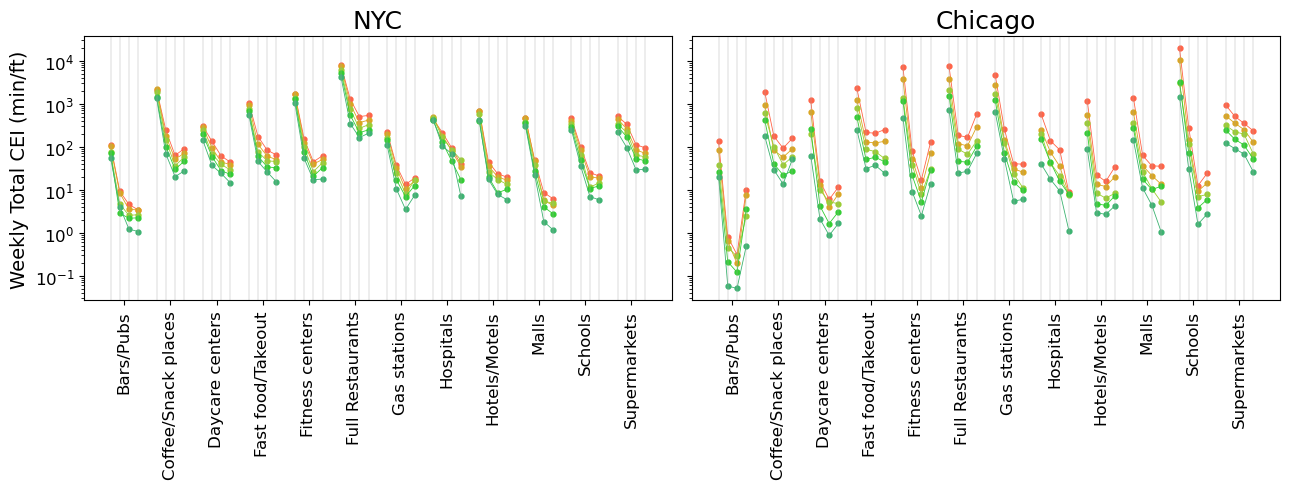

In [219]:
%%time
def exp_by_naics_n_inc(dpi=70):
    imp_wks = [200217, 200316, 200420, 200608]
    nWk = len(imp_wks) # = 3
    nCat = g.IMP_NAICS.shape[0] # = 12
    fig, ax = plt.subplots(1, 2, figsize=(13, 5), dpi=dpi, sharey=True)
    ax = ax.flatten()
    for i, c in enumerate([nyc, chi]):
        df = ((c.exp_od[c.exp_od['week'].isin(imp_wks)]
               .merge(g.IMP_NAICS['category'], on='naics')
               .merge(c.acs_zip['hh_inc_q'], left_on='home_zip', right_index=True)
               .groupby(['week', 'hh_inc_q', 'category'])
               [['exp_visits', 'tot_cei']].sum()/1e3).reset_index()
              .assign(avg_cei = lambda x: x['tot_cei']/x['exp_visits'])
              .sort_values(['category', 'week'])
              .astype({'category': 'category', 'week': 'category'}))
        df['xpos'] = (nWk+1)*df['category'].cat.codes + df['week'].cat.codes + 1
        if i == 1:
            df = df.assign(hh_inc_q = lambda x: x.hh_inc_q.map({1:3,2:5,3:4,4:2,5:1}))
        df['color'] = [g.COLORS['income_classes5'][x] for x in (df['hh_inc_q']-1)]
        
        # plot
        for _, sub in df.groupby(['category', 'hh_inc_q']):
            ax[i].plot(sub['xpos'], sub['tot_cei'], color=sub['color'].iloc[0],
                       marker='.', markersize=7, lw=0.6)
        for x in df['xpos'].unique():
            ax[i].axvline(x, color='darkgrey', lw=0.3)
        ax[i].set_yscale('log')
        ax[i].set_xticks(np.arange((nWk+1)/2, (nWk+1)*nCat, nWk+1))
        ax[i].set_xticklabels(df['category'].astype('str').unique(), rotation=90)
        ax[i].set_title(c.name, fontsize=18)
        if i == 0:
            ax[i].set_ylabel('Weekly Total CEI (min/ft)')
    plt.tight_layout()
    
exp_by_naics_n_inc(dpi=100)